In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取数据
light_data = pd.read_csv('/Users/hansen/Desktop/MATH3836proj/香港物种数据/2022年光强.csv')
species_data = pd.read_csv('/Users/hansen/Desktop/MATH3836proj/香港物种数据/2022年物种_最终版.csv')

# 检查并清理数据
# 确保经纬度列为数值型
light_data['latitude'] = pd.to_numeric(light_data['latitude'])
light_data['longitude'] = pd.to_numeric(light_data['longitude'])
species_data['latitude'] = pd.to_numeric(species_data['latitude'])
species_data['longitude'] = pd.to_numeric(species_data['longitude'])

# 确保nsb列(夜空亮度)为数值型
light_data['nsb'] = pd.to_numeric(light_data['nsb'])


In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    计算两个经纬度点之间的距离（单位：公里）
    """
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # 经纬度差值
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine公式
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    
    return c * r

# 为每个物种观测点找到所有2公里范围内的光照观测站
def find_nearby_light_stations(species_row, light_data):
    """
    找到距离物种观测点2公里以内的所有光照观测站
    """
    nearby_stations = []
    
    for _, light_row in light_data.iterrows():
        # 如果光照观测月份与物种观测月份相同
        if light_row['month'] == species_row['month']:
            dist = haversine_distance(
                species_row['latitude'], species_row['longitude'],
                light_row['latitude'], light_row['longitude']
            )
            
            if dist < 2:  # 如果距离小于2公里
                nearby_stations.append({
                    'station': light_row['location'],
                    'distance': dist,
                    'nsb': light_row['nsb']
                })
    
    return nearby_stations

# 为每个物种观测点分配光照强度
species_with_light = []

for _, species_row in species_data.iterrows():
    nearby_stations = find_nearby_light_stations(species_row, light_data)
    
    if nearby_stations:  # 如果有附近的光照观测站
        # 计算平均光照强度
        avg_nsb = sum(station['nsb'] for station in nearby_stations) / len(nearby_stations)
        
        species_with_light.append({
            'scientific': species_row['scientific'],
            'month': species_row['month'],
            'gno': species_row['gno'],
            'count': species_row['count'],
            'latitude': species_row['latitude'],
            'longitude': species_row['longitude'],
            'nsb': avg_nsb,
            'stations_count': len(nearby_stations),
            'stations': [s['station'] for s in nearby_stations]
        })
    else:
        # 没有附近的光照观测站，标记为缺失值
        species_with_light.append({
            'scientific': species_row['scientific'],
            'month': species_row['month'],
            'gno': species_row['gno'],
            'count': species_row['count'],
            'latitude': species_row['latitude'],
            'longitude': species_row['longitude'],
            'nsb': None,
            'stations_count': 0,
            'stations': []
        })

# 转换为DataFrame
result_df = pd.DataFrame(species_with_light)


In [4]:
# 过滤掉没有匹配到光照强度的观测点
valid_data = result_df.dropna(subset=['nsb'])

# 基本统计描述
print("数据概览：")
print(f"总物种观测点数量: {len(species_data)}")
print(f"匹配到光照强度的观测点数量: {len(valid_data)}")
print(f"匹配成功率: {len(valid_data)/len(species_data)*100:.2f}%")





数据概览：
总物种观测点数量: 11178
匹配到光照强度的观测点数量: 2974
匹配成功率: 26.61%


研究物种种类和光照的关系

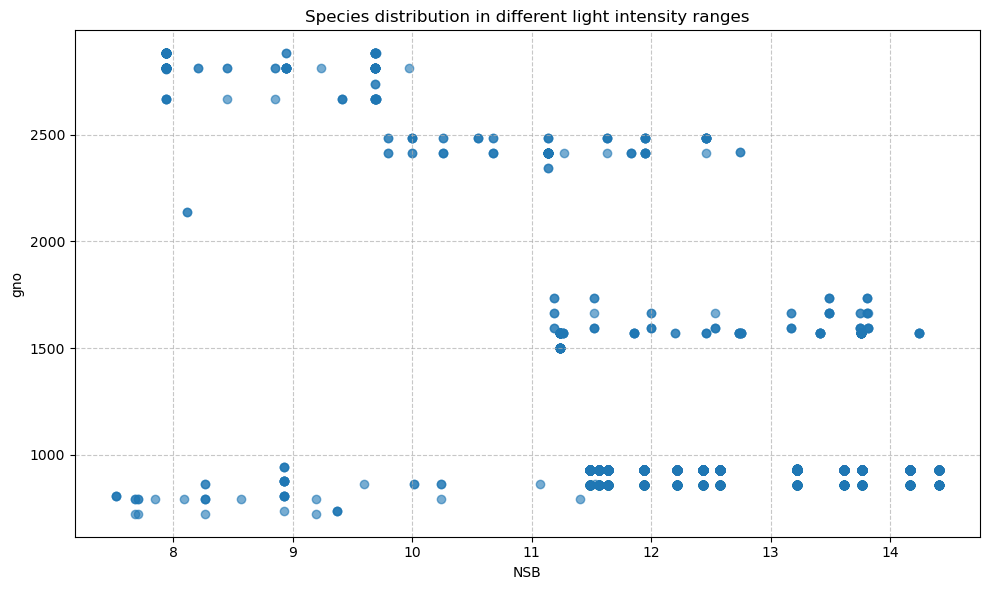

/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_12118/2847321363.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['nsb_category'] = pd.cut(valid_data['nsb'],


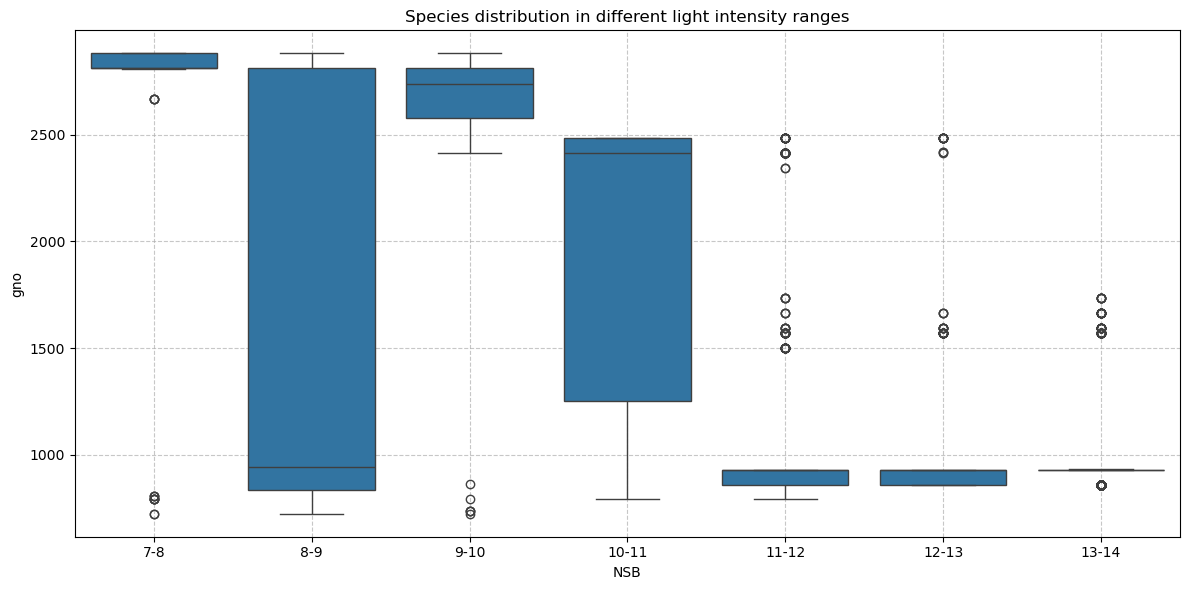

In [8]:
# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(valid_data['nsb'], valid_data['gno'], alpha=0.6)
plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/光照强度与物种数量散点图.png')
plt.show()

# 创建箱线图，按照光照强度范围分组
# 将光照强度分为几个区间
valid_data['nsb_category'] = pd.cut(valid_data['nsb'], 
                                   bins=[7, 8, 9, 10, 11, 12, 13, 14],
                                   labels=['7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='nsb_category', y='gno', data=valid_data)
plt.title('Species distribution in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/不同光照强度区间的物种数量箱线图.png')
plt.show()


Pearson相关系数: -0.5655
P值: 0.0000
相关性: 统计显著
线性回归模型:
系数: -202.0248
截距: 3578.9085
R²: 0.3198
RMSE: 406.2781


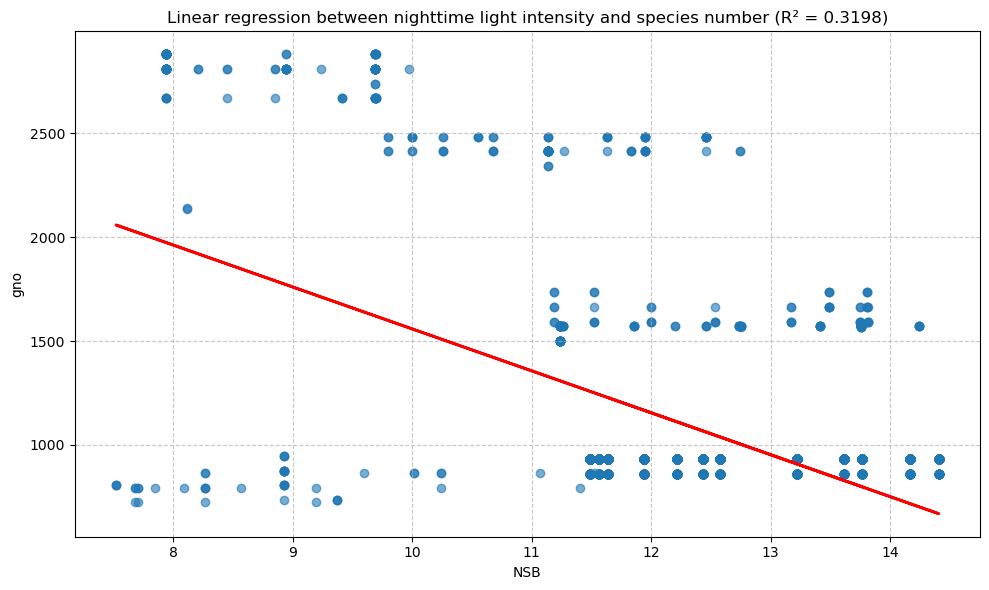

In [10]:
# 计算相关系数
correlation, p_value = stats.pearsonr(valid_data['nsb'], valid_data['gno'])
print(f"Pearson相关系数: {correlation:.4f}")
print(f"P值: {p_value:.4f}")

# 如果P值小于0.05，相关性统计显著
if p_value < 0.05:
    significance = "统计显著"
else:
    significance = "统计不显著"
    
print(f"相关性: {significance}")

# 线性回归模型
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = valid_data[['nsb']]
y = valid_data['gno']

model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 模型评估
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"线性回归模型:")
print(f"系数: {model.coef_[0]:.4f}")
print(f"截距: {model.intercept_:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# 绘制回归线
plt.figure(figsize=(10, 6))
plt.scatter(valid_data['nsb'], valid_data['gno'], alpha=0.6)
plt.plot(valid_data['nsb'], y_pred, color='red', linewidth=2)
plt.title(f'Linear regression between nighttime light intensity and species number (R² = {r2:.4f})')
plt.xlabel('NSB')
plt.ylabel('gno')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/Users/hansen/Desktop/光照强度与物种数量回归分析.png')
plt.show()

# 保存结果到CSV
# valid_data.to_csv('/Users/hansen/Desktop/物种与光照关联分析结果.csv', index=False)


研究物种种类和光照的关系

In [13]:
# 使用经纬度组合来唯一标识地理位置
# 由于经纬度可能有微小浮点数差异，先将经纬度四舍五入到固定小数位
valid_data['latitude_rounded'] = valid_data['latitude'].round(5)
valid_data['longitude_rounded'] = valid_data['longitude'].round(5)

# 按照经纬度和月份分组，计算每个地点-月份组合的不同物种数量
location_species_richness = valid_data.groupby(['latitude_rounded', 'longitude_rounded', 'month']).agg({
    'scientific': 'nunique',  # 计算不同物种数量
    'nsb': 'mean',  # 取该地点-月份的平均光照强度
    'latitude': 'first',  # 保留原始地理位置信息
    'longitude': 'first'
}).reset_index()

# 重命名列以更好地反映其含义
location_species_richness.rename(columns={'scientific': 'species_richness'}, inplace=True)

print("数据概览：")
print(f"总观测地点-月份组合数: {len(location_species_richness)}")
print(f"平均每个地点-月份的物种种类数: {location_species_richness['species_richness'].mean():.2f}")
print(f"最大物种种类数: {location_species_richness['species_richness'].max()}")
print(f"最小物种种类数: {location_species_richness['species_richness'].min()}")


数据概览：
总观测地点-月份组合数: 146
平均每个地点-月份的物种种类数: 20.37
最大物种种类数: 123
最小物种种类数: 1


/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_12118/303737849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['latitude_rounded'] = valid_data['latitude'].round(5)
/var/folders/_p/fnnym9496hj_jzyg9y4_36nm0000gn/T/ipykernel_12118/303737849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['longitude_rounded'] = valid_data['longitude'].round(5)


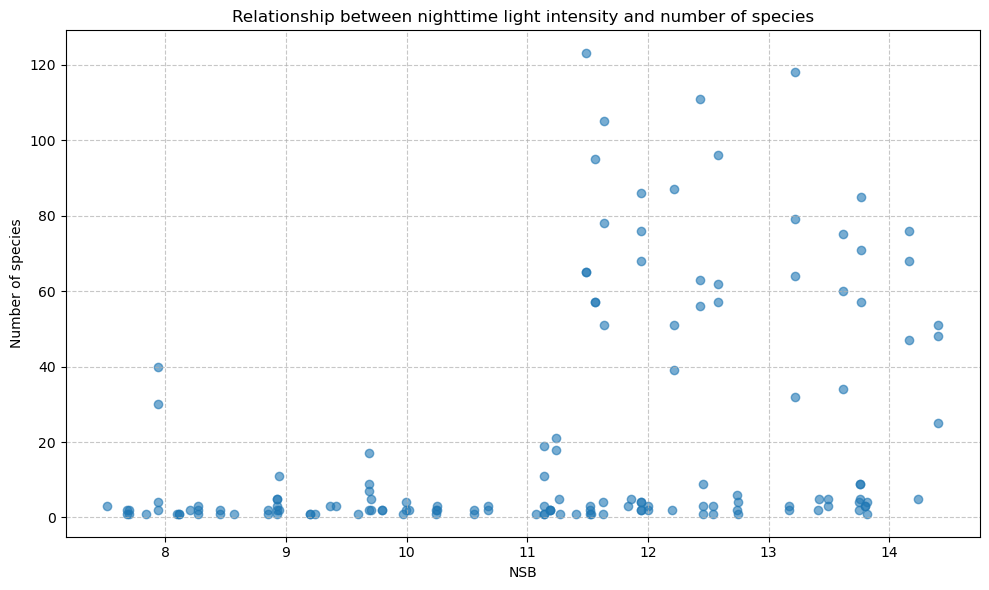

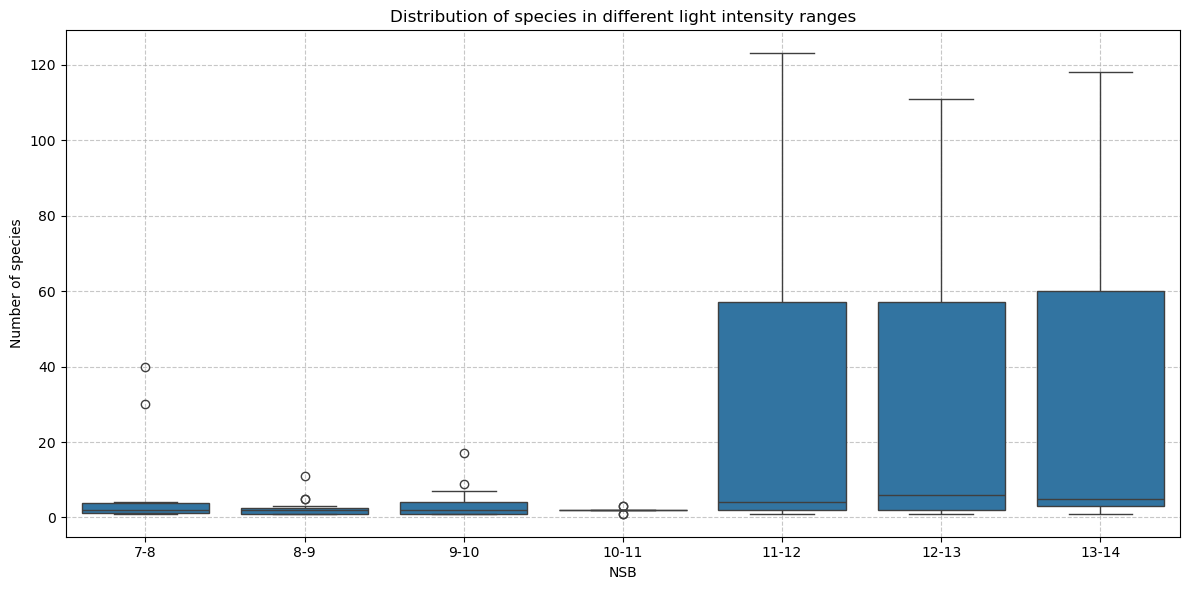

In [15]:
# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(location_species_richness['nsb'], location_species_richness['species_richness'], alpha=0.6)
plt.title('Relationship between nighttime light intensity and number of species')
plt.xlabel('NSB')
plt.ylabel('Number of species')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/光照强度与物种种类数散点图.png')
plt.show()

# 创建箱线图，按照光照强度范围分组
location_species_richness['nsb_category'] = pd.cut(
    location_species_richness['nsb'], 
    bins=[7, 8, 9, 10, 11, 12, 13, 14],
    labels=['7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14']
)

plt.figure(figsize=(12, 6))
sns.boxplot(x='nsb_category', y='species_richness', data=location_species_richness)
plt.title('Distribution of species in different light intensity ranges')
plt.xlabel('NSB')
plt.ylabel('Number of species')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/不同光照强度区间的物种种类数箱线图.png')
plt.show()


Pearson相关系数: 0.3908
P值: 0.0000
相关性: 统计显著
线性回归模型:
系数: 6.2111
截距: -49.2321
R²: 0.1527
RMSE: 28.2994


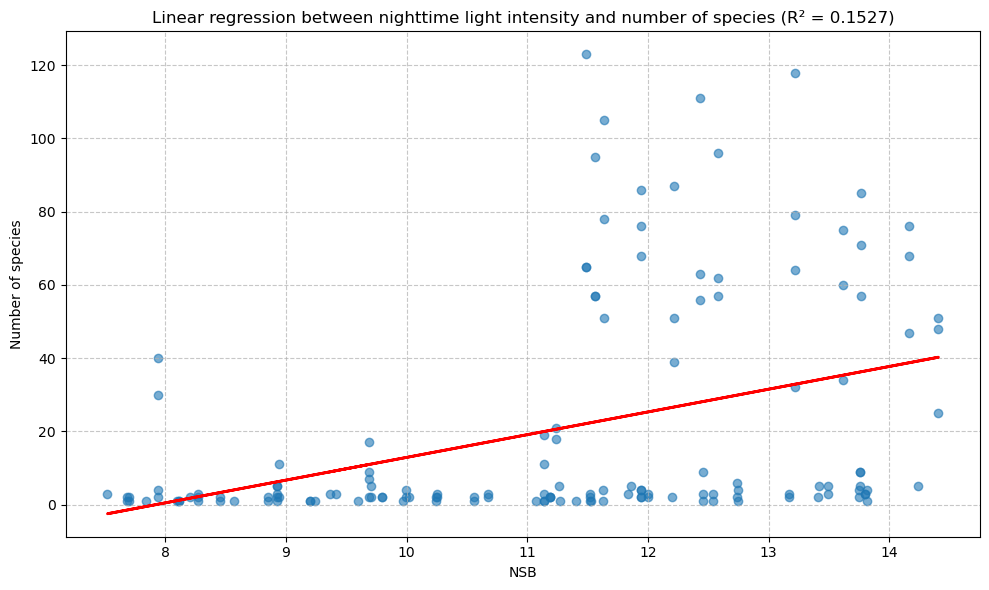

In [17]:
# 计算相关系数
correlation, p_value = stats.pearsonr(
    location_species_richness['nsb'], 
    location_species_richness['species_richness']
)
print(f"Pearson相关系数: {correlation:.4f}")
print(f"P值: {p_value:.4f}")

# 如果P值小于0.05，相关性统计显著
if p_value < 0.05:
    significance = "统计显著"
else:
    significance = "统计不显著"
    
print(f"相关性: {significance}")

# 线性回归模型
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = location_species_richness[['nsb']]
y = location_species_richness['species_richness']

model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 模型评估
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"线性回归模型:")
print(f"系数: {model.coef_[0]:.4f}")
print(f"截距: {model.intercept_:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# 绘制回归线
plt.figure(figsize=(10, 6))
plt.scatter(location_species_richness['nsb'], location_species_richness['species_richness'], alpha=0.6)
plt.plot(location_species_richness['nsb'], y_pred, color='red', linewidth=2)
plt.title(f'Linear regression between nighttime light intensity and number of species (R² = {r2:.4f})')
plt.xlabel('NSB')
plt.ylabel('Number of species')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('/Users/hansen/Desktop/光照强度与物种种类数回归分析.png')
plt.show()


选择了9个最常见的观测点位置

多元回归模型 (光照强度 + 地理位置):
R²: 0.8992
RMSE: 156.3771

回归系数:
     Variable  Coefficient
0         NSB    11.505617
1  Location 1  -722.234949
2  Location 2  -723.141848
3  Location 3  -791.704421
4  Location 4  1204.223348
5  Location 5  1277.869707
6  Location 6   -83.625567
7  Location 7   778.234566
8  Location 8   846.578415
9  Location 9  -727.253154
截距: 1507.1294

模型比较:
单变量模型 (仅光照强度) R²: 0.1527
多变量模型 (光照强度 + 地理位置) R²: 0.8992
R²提升: 0.7465


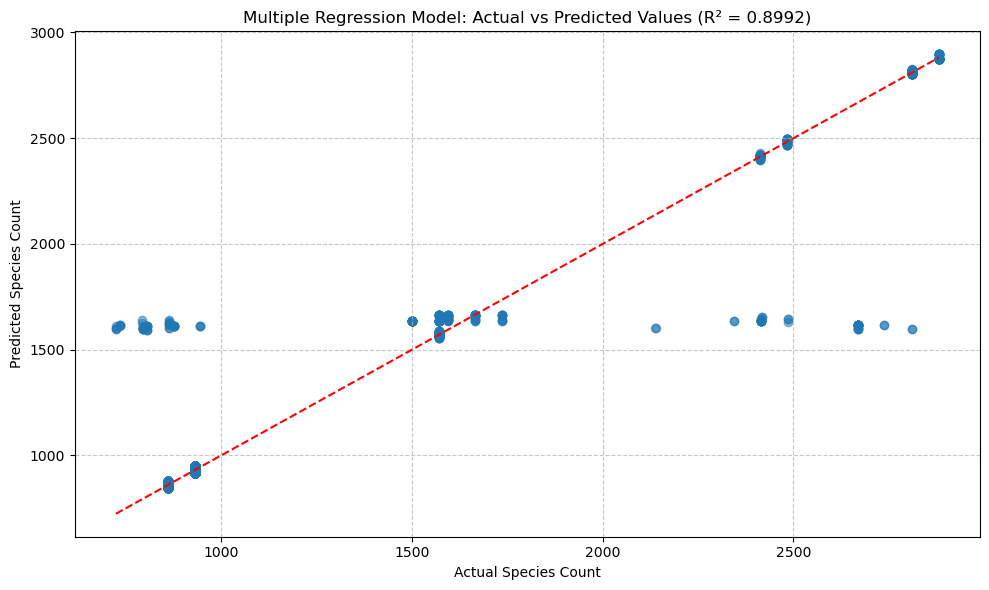

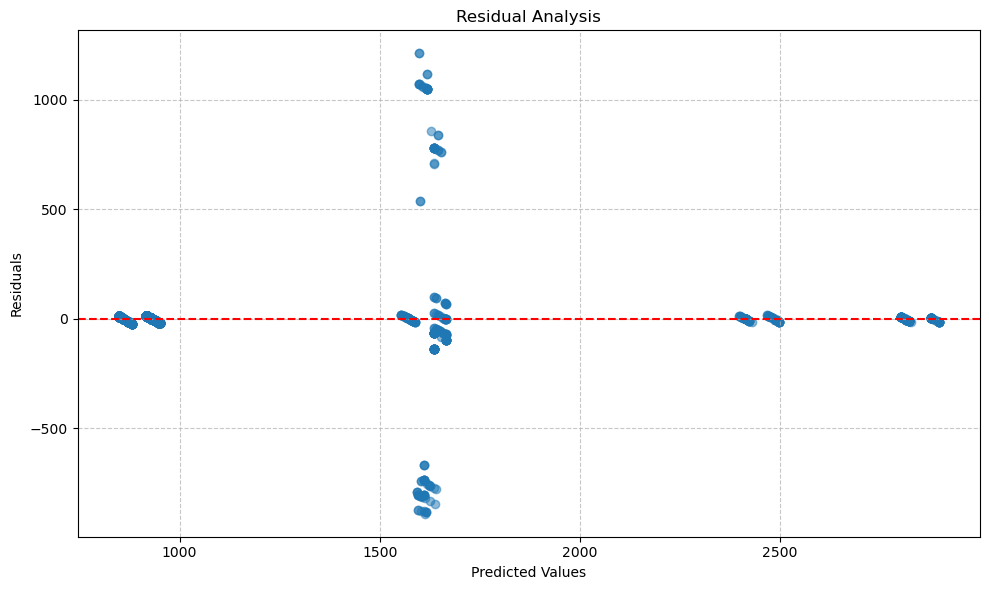


各变量组对R²的贡献:
仅光照强度: 0.3198
仅地理位置: 0.8986
光照强度 + 地理位置: 0.8992


In [19]:
# 创建一个新的数据框，用于多元回归分析
multi_reg_data = valid_data.copy()

# 提取唯一的观测点位置（使用经纬度组合）
# 为了确保唯一性，使用之前创建的rounded经纬度
location_pairs = multi_reg_data[['latitude_rounded', 'longitude_rounded']].drop_duplicates()
location_pairs = location_pairs.reset_index(drop=True)

# 只选择前9个最常见的观测点位置（如果有超过9个的话）
top_locations = multi_reg_data.groupby(['latitude_rounded', 'longitude_rounded']).size().reset_index(name='count')
top_locations = top_locations.sort_values('count', ascending=False).head(9)
print(f"选择了{len(top_locations)}个最常见的观测点位置")

# 为每个观测点创建哑变量
for i, (_, row) in enumerate(top_locations.iterrows(), 1):
    lat, lon = row['latitude_rounded'], row['longitude_rounded']
    col_name = f'location_{i}'
    multi_reg_data[col_name] = ((multi_reg_data['latitude_rounded'] == lat) & 
                               (multi_reg_data['longitude_rounded'] == lon)).astype(int)

# 准备多元回归的自变量和因变量
X_columns = ['nsb'] + [f'location_{i}' for i in range(1, len(top_locations) + 1)]
X_multi = multi_reg_data[X_columns]
y_multi = multi_reg_data['gno']  # gno是物种数量

# 创建多元回归模型
from sklearn.linear_model import LinearRegression

multi_model = LinearRegression()
multi_model.fit(X_multi, y_multi)

# 预测值
y_multi_pred = multi_model.predict(X_multi)

# 模型评估
multi_r2 = r2_score(y_multi, y_multi_pred)
multi_rmse = np.sqrt(mean_squared_error(y_multi, y_multi_pred))

print(f"\n多元回归模型 (光照强度 + 地理位置):")
print(f"R²: {multi_r2:.4f}")
print(f"RMSE: {multi_rmse:.4f}")

# 打印系数
coef_df = pd.DataFrame({
    'Variable': ['NSB'] + [f'Location {i}' for i in range(1, len(top_locations) + 1)],
    'Coefficient': [multi_model.coef_[0]] + list(multi_model.coef_[1:])
})
print("\n回归系数:")
print(coef_df)
print(f"截距: {multi_model.intercept_:.4f}")

# 比较单变量和多变量模型
print("\n模型比较:")
print(f"单变量模型 (仅光照强度) R²: {r2:.4f}")
print(f"多变量模型 (光照强度 + 地理位置) R²: {multi_r2:.4f}")
print(f"R²提升: {multi_r2 - r2:.4f}")

# 可视化实际值与预测值的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_multi, y_multi_pred, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.title(f'Multiple Regression Model: Actual vs Predicted Values (R² = {multi_r2:.4f})')
plt.xlabel('Actual Species Count')
plt.ylabel('Predicted Species Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 残差分析
residuals = y_multi - y_multi_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_multi_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 计算每个变量对R²的贡献
from sklearn.linear_model import LinearRegression

# 仅使用NSB的模型
X_nsb = multi_reg_data[['nsb']]
nsb_model = LinearRegression().fit(X_nsb, y_multi)
nsb_r2 = r2_score(y_multi, nsb_model.predict(X_nsb))

# 仅使用位置的模型
X_loc = multi_reg_data[[f'location_{i}' for i in range(1, len(top_locations) + 1)]]
loc_model = LinearRegression().fit(X_loc, y_multi)
loc_r2 = r2_score(y_multi, loc_model.predict(X_loc))

print("\n各变量组对R²的贡献:")
print(f"仅光照强度: {nsb_r2:.4f}")
print(f"仅地理位置: {loc_r2:.4f}")
print(f"光照强度 + 地理位置: {multi_r2:.4f}")


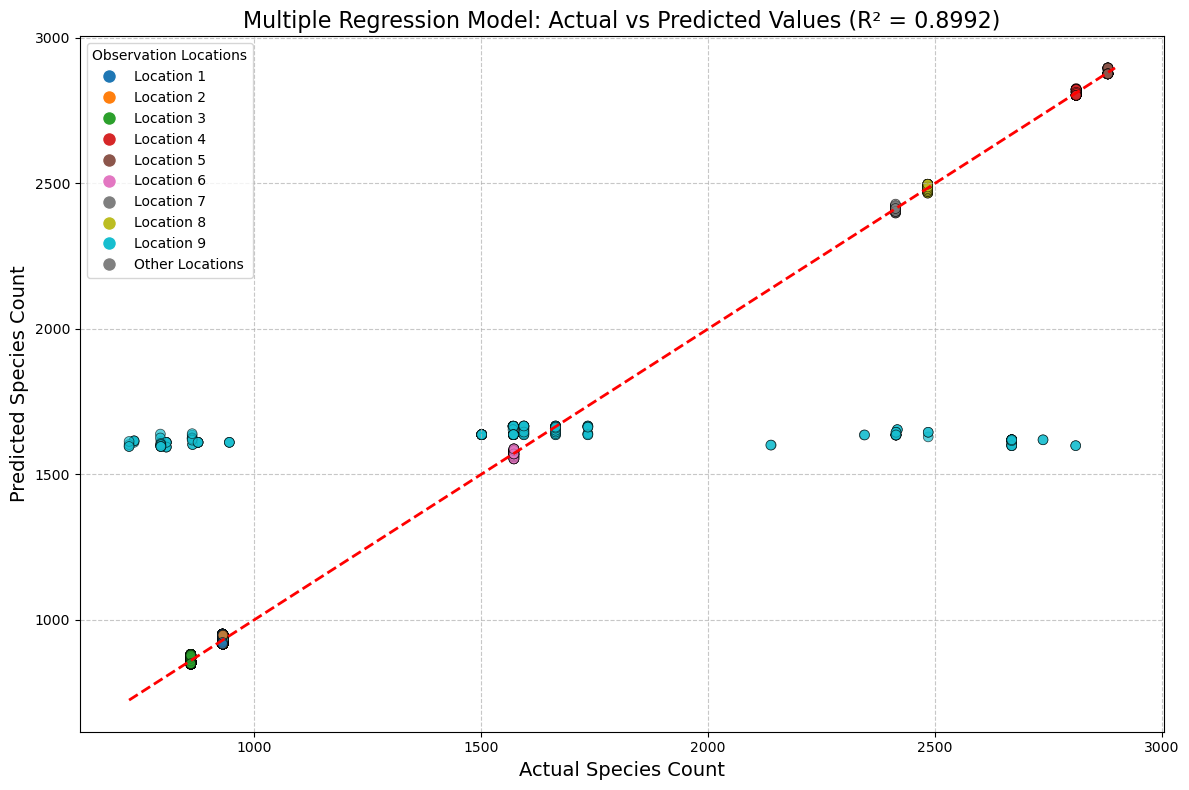

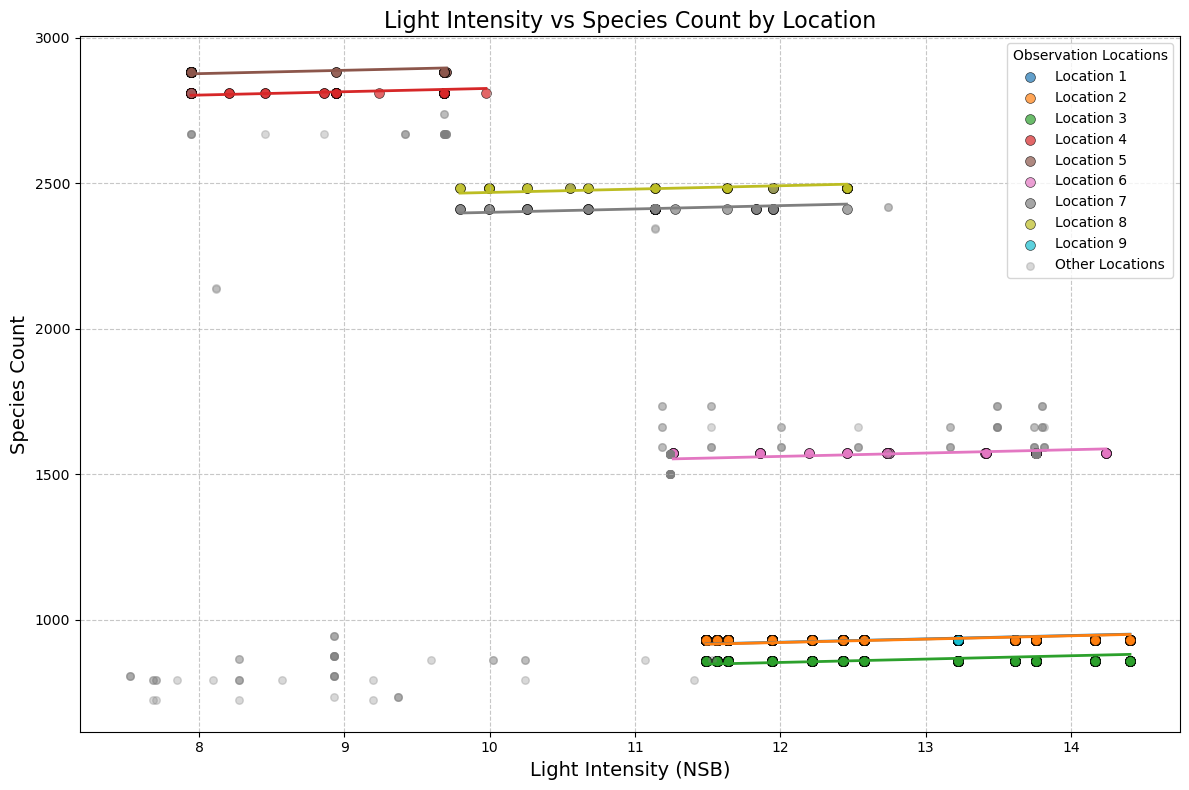

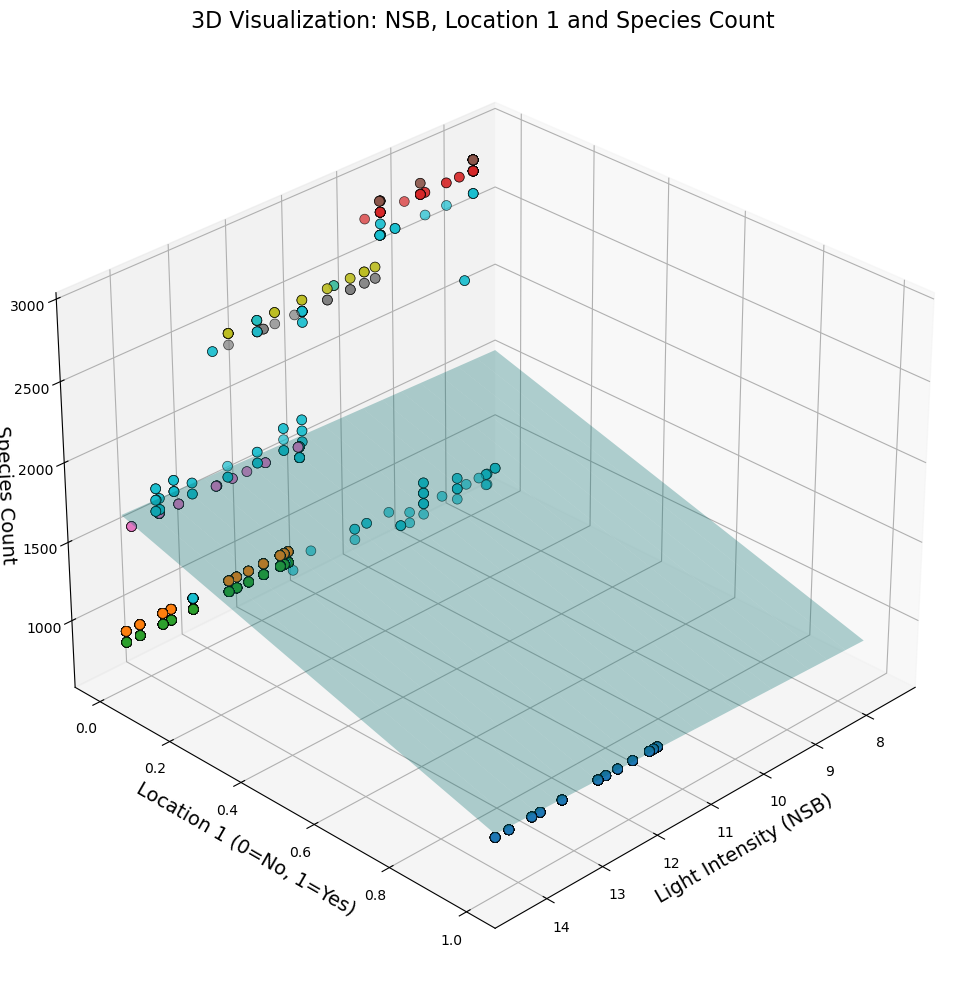

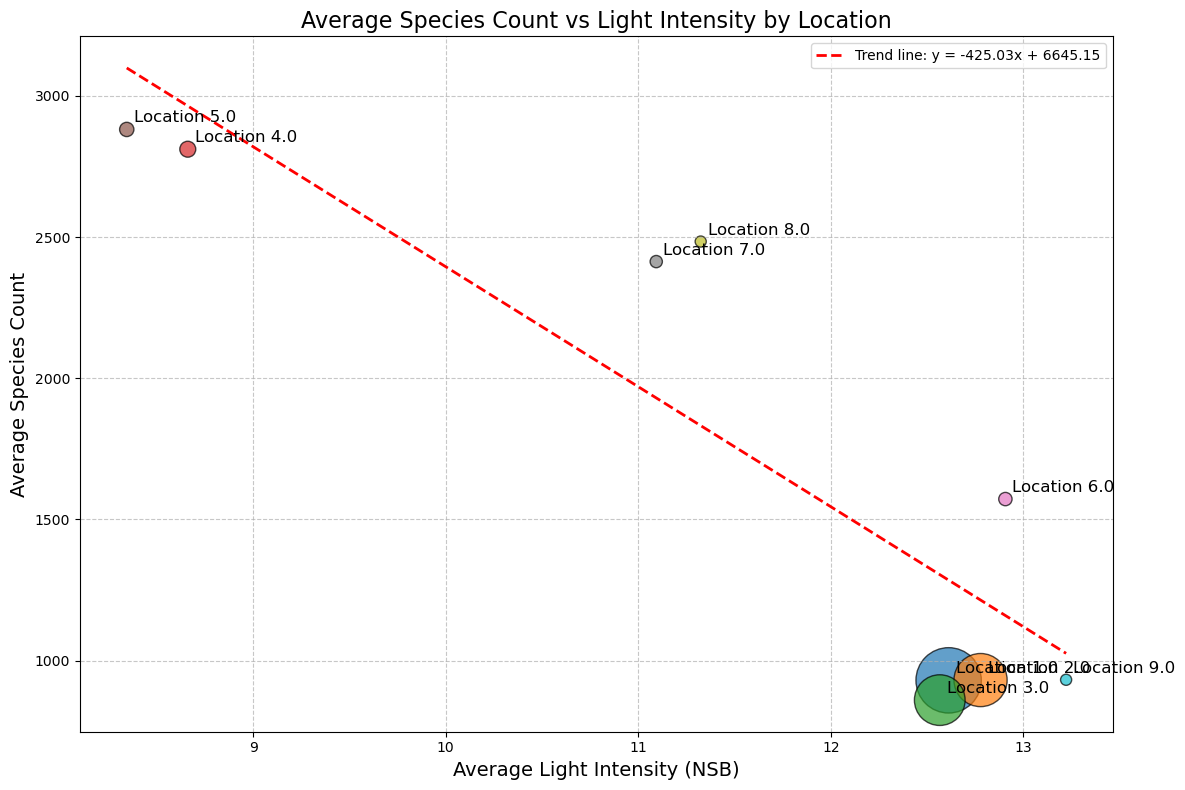

In [21]:
# 创建回归模型拟合散点图
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# 1. 实际值与预测值对比散点图（带有颜色区分不同位置）
plt.figure(figsize=(12, 8))

# 创建彩色映射以区分不同位置
num_locations = len(top_locations)
colors = plt.cm.tab10(np.linspace(0, 1, num_locations))
cmap = ListedColormap(colors)

# 为每个数据点确定其位置类别（用于着色）
location_category = np.zeros(len(multi_reg_data))
for i in range(1, num_locations + 1):
    location_category += i * multi_reg_data[f'location_{i}']
    
# 对于不在top_locations中的点，标记为0
location_category[location_category == 0] = num_locations + 1

# 绘制散点图，颜色表示不同位置
scatter = plt.scatter(y_multi, y_multi_pred, c=location_category, cmap=cmap, 
                     alpha=0.7, s=50, edgecolor='k', linewidth=0.5)

# 添加对角线（完美预测线）
min_val = min(y_multi.min(), y_multi_pred.min())
max_val = max(y_multi.max(), y_multi_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction Line')

# 添加图例
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
                             markersize=10, label=f'Location {i+1}') 
                  for i in range(num_locations)]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='gray', markersize=10, label='Other Locations'))
plt.legend(handles=legend_elements, title='Observation Locations', loc='upper left')

plt.title(f'Multiple Regression Model: Actual vs Predicted Values (R² = {multi_r2:.4f})', fontsize=16)
plt.xlabel('Actual Species Count', fontsize=14)
plt.ylabel('Predicted Species Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. 光照强度与物种数量的关系（按位置分组）
plt.figure(figsize=(12, 8))

# 为每个位置绘制散点图和回归线
for i in range(1, num_locations + 1):
    # 提取特定位置的数据
    location_data = multi_reg_data[multi_reg_data[f'location_{i}'] == 1]
    
    if len(location_data) > 0:  # 确保有数据
        plt.scatter(location_data['nsb'], location_data['gno'], 
                   color=colors[i-1], alpha=0.7, s=50, 
                   edgecolor='k', linewidth=0.5, label=f'Location {i}')
        
        # 为该位置添加回归线
        if len(location_data) > 1:  # 至少需要两个点来拟合线
            x_range = np.linspace(location_data['nsb'].min(), location_data['nsb'].max(), 100)
            # 使用多元回归模型的系数计算预测值
            # 注意：这里我们只考虑NSB的影响和该位置的影响
            y_pred = (multi_model.intercept_ + 
                     multi_model.coef_[0] * x_range + 
                     multi_model.coef_[i])
            plt.plot(x_range, y_pred, color=colors[i-1], linewidth=2)

# 添加其他位置的数据点
other_locations = multi_reg_data.copy()
for i in range(1, num_locations + 1):
    other_locations = other_locations[other_locations[f'location_{i}'] == 0]
    
if len(other_locations) > 0:
    plt.scatter(other_locations['nsb'], other_locations['gno'], 
               color='gray', alpha=0.3, s=30, label='Other Locations')

plt.title('Light Intensity vs Species Count by Location', fontsize=16)
plt.xlabel('Light Intensity (NSB)', fontsize=14)
plt.ylabel('Species Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Observation Locations', loc='best')
plt.tight_layout()
plt.show()

# 3. 3D可视化（仅使用前两个位置变量和NSB）
if num_locations >= 2:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制原始数据点
    scatter = ax.scatter(multi_reg_data['nsb'], 
                        multi_reg_data['location_1'], 
                        multi_reg_data['gno'],
                        c=location_category, cmap=cmap, 
                        s=50, alpha=0.7, edgecolor='k', linewidth=0.5)
    
    # 创建网格以绘制预测平面
    x_range = np.linspace(multi_reg_data['nsb'].min(), multi_reg_data['nsb'].max(), 20)
    y_range = np.array([0, 1])  # location_1的两个可能值
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros(X.shape)
    
    # 计算预测平面
    for i in range(len(y_range)):
        for j in range(len(x_range)):
            # 创建预测点 (NSB, location_1, location_2, ...)
            pred_point = np.zeros(len(X_columns))
            pred_point[0] = X[i,j]  # NSB
            pred_point[1] = Y[i,j]  # location_1
            # 假设其他位置变量都为0
            Z[i,j] = multi_model.intercept_ + np.dot(multi_model.coef_, pred_point)
    
    # 绘制预测平面
    ax.plot_surface(X, Y, Z, alpha=0.3, color='cyan')
    
    ax.set_title('3D Visualization: NSB, Location 1 and Species Count', fontsize=16)
    ax.set_xlabel('Light Intensity (NSB)', fontsize=14)
    ax.set_ylabel('Location 1 (0=No, 1=Yes)', fontsize=14)
    ax.set_zlabel('Species Count', fontsize=14)
    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()

# 4. 每个位置的平均物种数量与光照强度关系
plt.figure(figsize=(12, 8))

# 计算每个位置的平均物种数量和光照强度
location_stats = []
for i in range(1, num_locations + 1):
    location_data = multi_reg_data[multi_reg_data[f'location_{i}'] == 1]
    if len(location_data) > 0:
        location_stats.append({
            'location': i,
            'avg_gno': location_data['gno'].mean(),
            'avg_nsb': location_data['nsb'].mean(),
            'count': len(location_data)
        })

# 创建DataFrame
location_stats_df = pd.DataFrame(location_stats)

# 绘制散点图，点大小表示数据点数量
plt.scatter(location_stats_df['avg_nsb'], location_stats_df['avg_gno'], 
           s=location_stats_df['count']*2, c=colors[:len(location_stats_df)], 
           alpha=0.7, edgecolor='k', linewidth=1)

# 添加位置标签
for i, row in location_stats_df.iterrows():
    plt.annotate(f"Location {row['location']}", 
                (row['avg_nsb'], row['avg_gno']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12)

# 拟合一条趋势线
if len(location_stats_df) > 1:
    z = np.polyfit(location_stats_df['avg_nsb'], location_stats_df['avg_gno'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(location_stats_df['avg_nsb'].min(), location_stats_df['avg_nsb'].max(), 100)
    plt.plot(x_trend, p(x_trend), "r--", linewidth=2, 
             label=f"Trend line: y = {z[0]:.2f}x + {z[1]:.2f}")

plt.title('Average Species Count vs Light Intensity by Location', fontsize=16)
plt.xlabel('Average Light Intensity (NSB)', fontsize=14)
plt.ylabel('Average Species Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


选择了9个最常见的观测点位置

模型比较:

Basic Multiple Regression:
R²: 0.8992
RMSE: 156.3771
系数:
  nsb: 11.5056
  location_1: -722.2349
  location_2: -723.1418
  location_3: -791.7044
  location_4: 1204.2233
  location_5: 1277.8697
  location_6: -83.6256
  location_7: 778.2346
  location_8: 846.5784
  location_9: -727.2532
截距: 1507.1294

Light × Location Interaction:
R²: 0.9012
RMSE: 154.8380
前10个系数 (共19个):
  nsb: 50.6501
  location_1: -146.8163
  location_2: -145.8163
  location_3: -216.8163
  location_4: 1734.1837
  location_5: 1804.1837
  location_6: 495.1837
  location_7: 1336.1837
  location_8: 1407.1837
  location_9: -4.6327
截距: 1076.8163

Quadratic Light Term:
R²: 0.9025
RMSE: 153.8107
前10个系数 (共11个):
  nsb: 316.4998
  location_1: -775.2249
  location_2: -773.4386
  location_3: -845.2721
  location_4: 1309.0898
  location_5: 1411.9256
  location_6: -134.0412
  location_7: 735.3761
  location_8: 804.1708
  location_9: -781.8805
截距: -301.4787

Quadratic Light × Location:
R²: 0.9043
RMSE: 152.4058
前

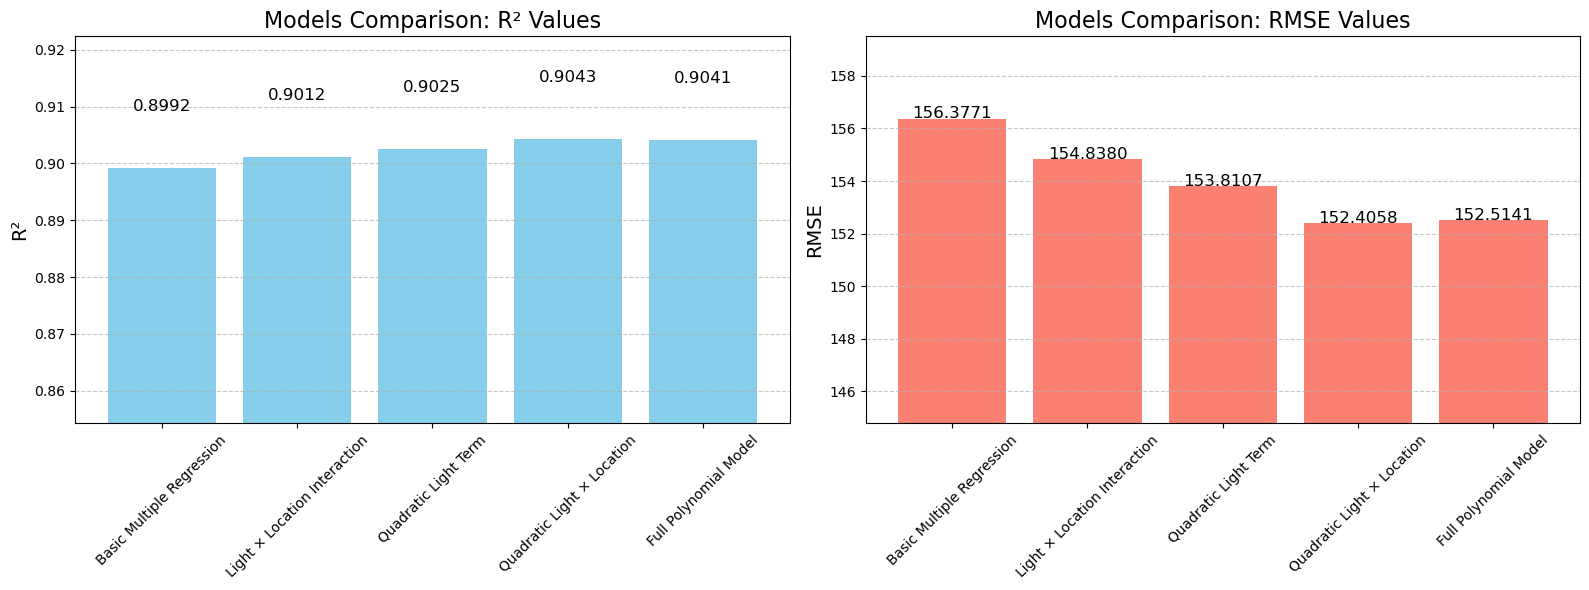

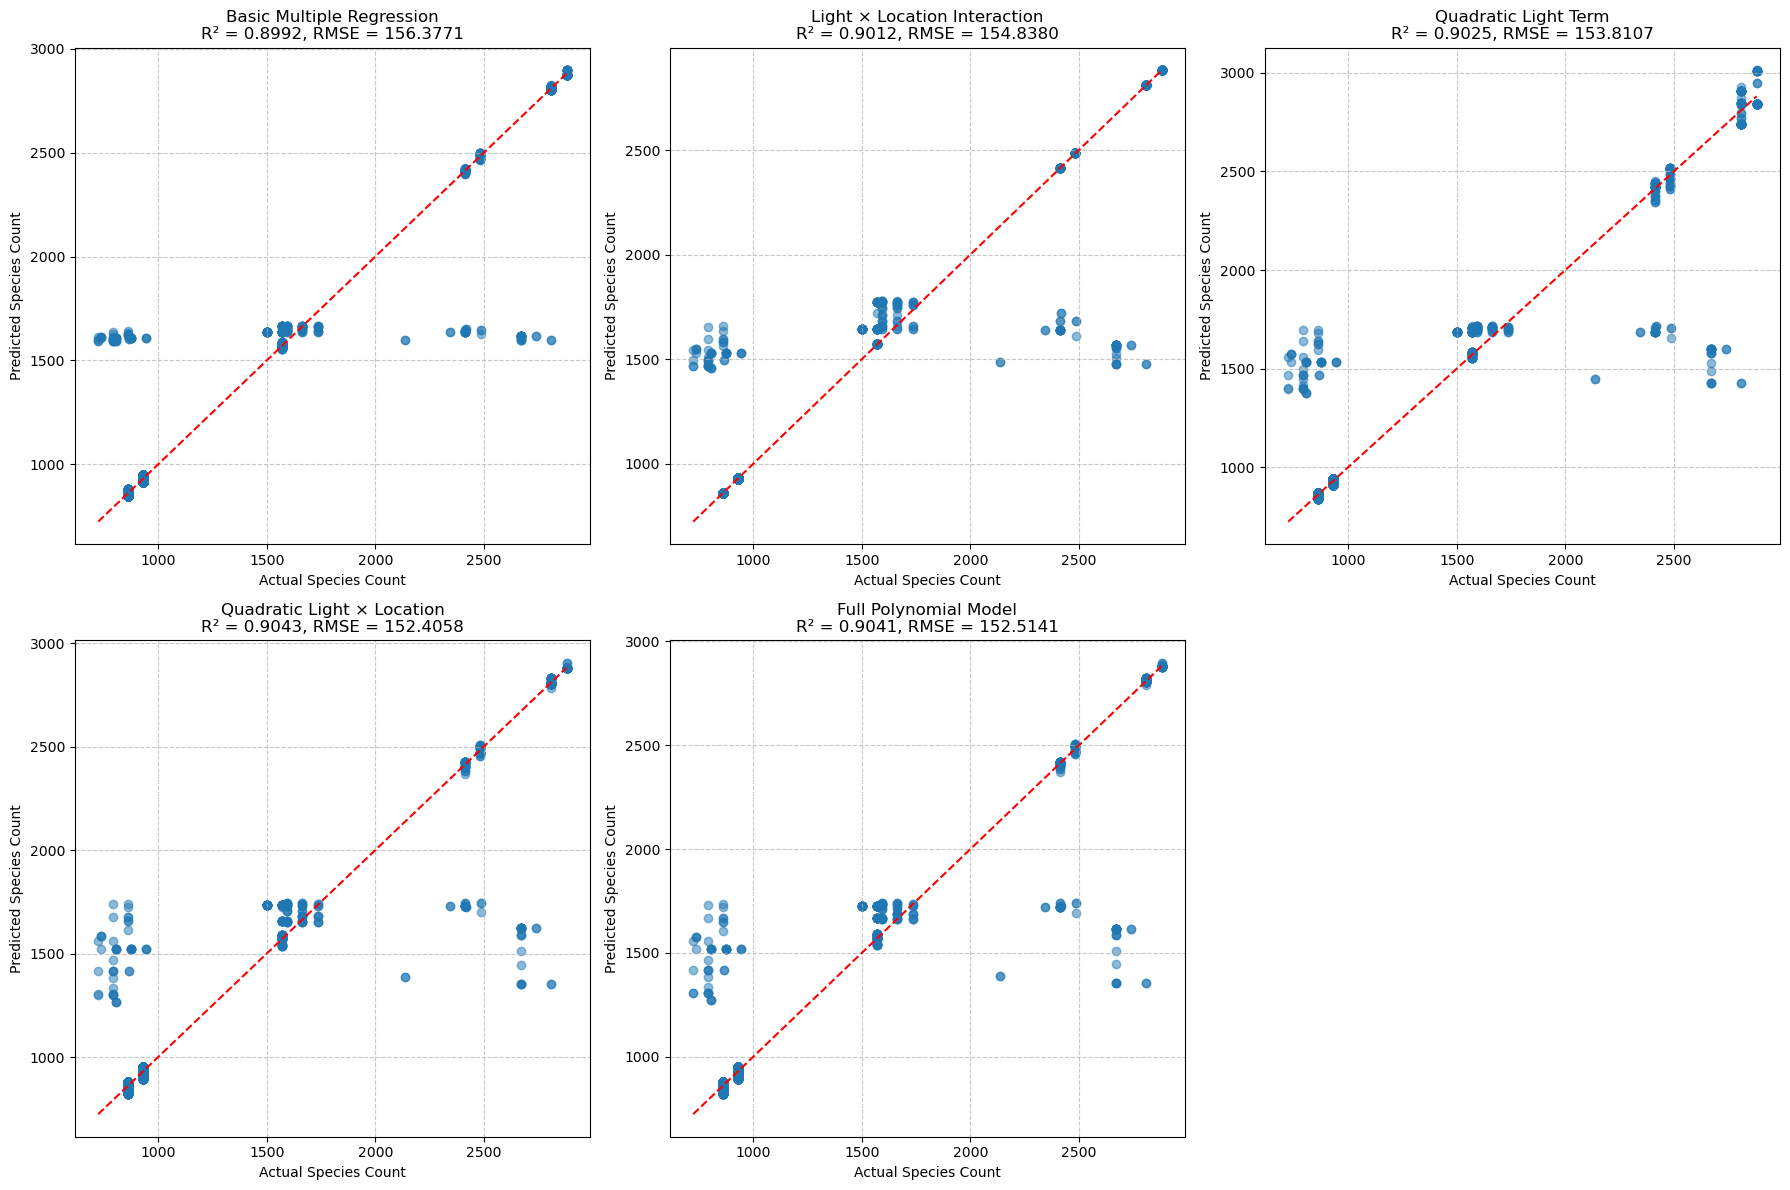

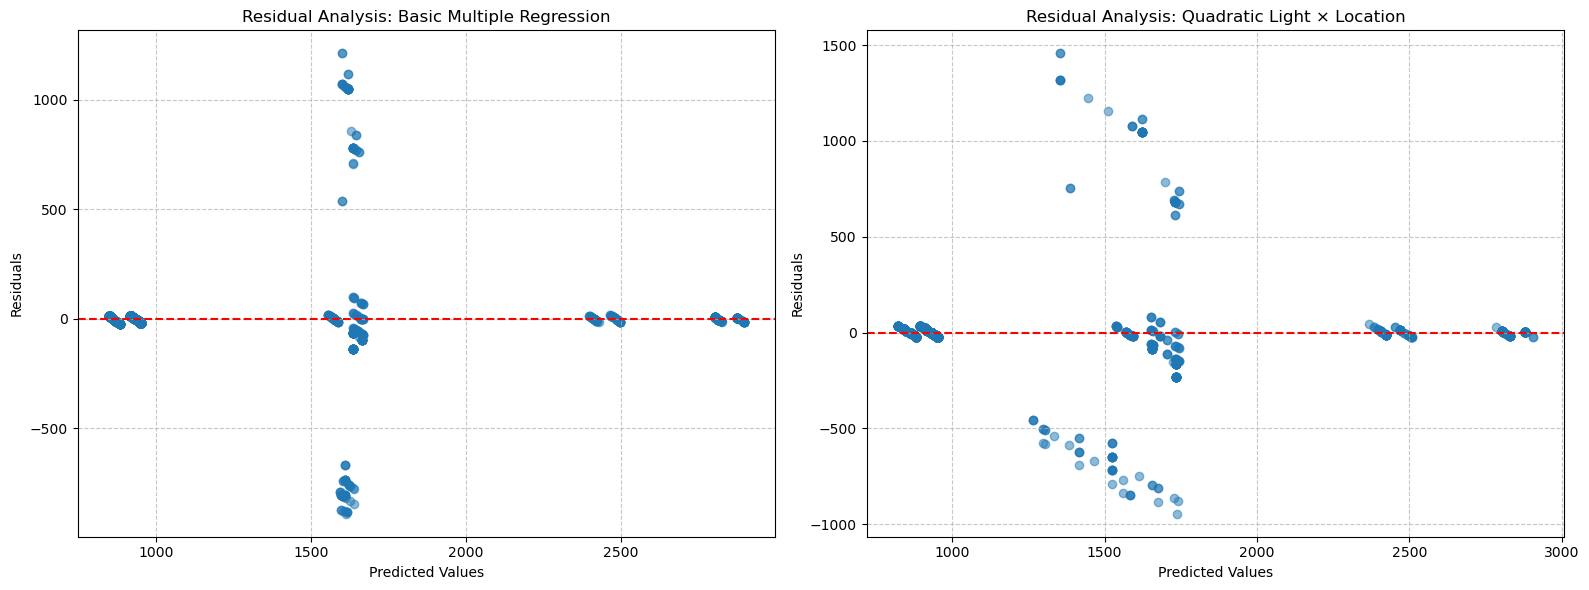

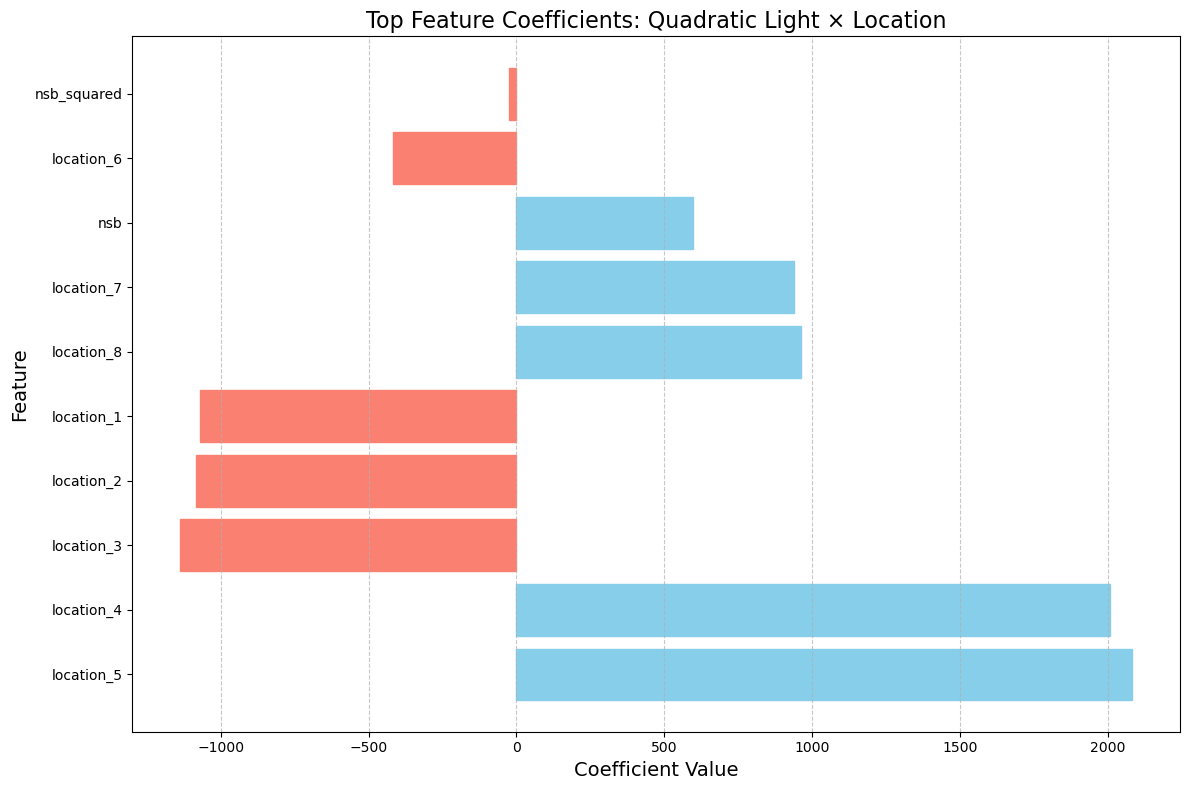

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


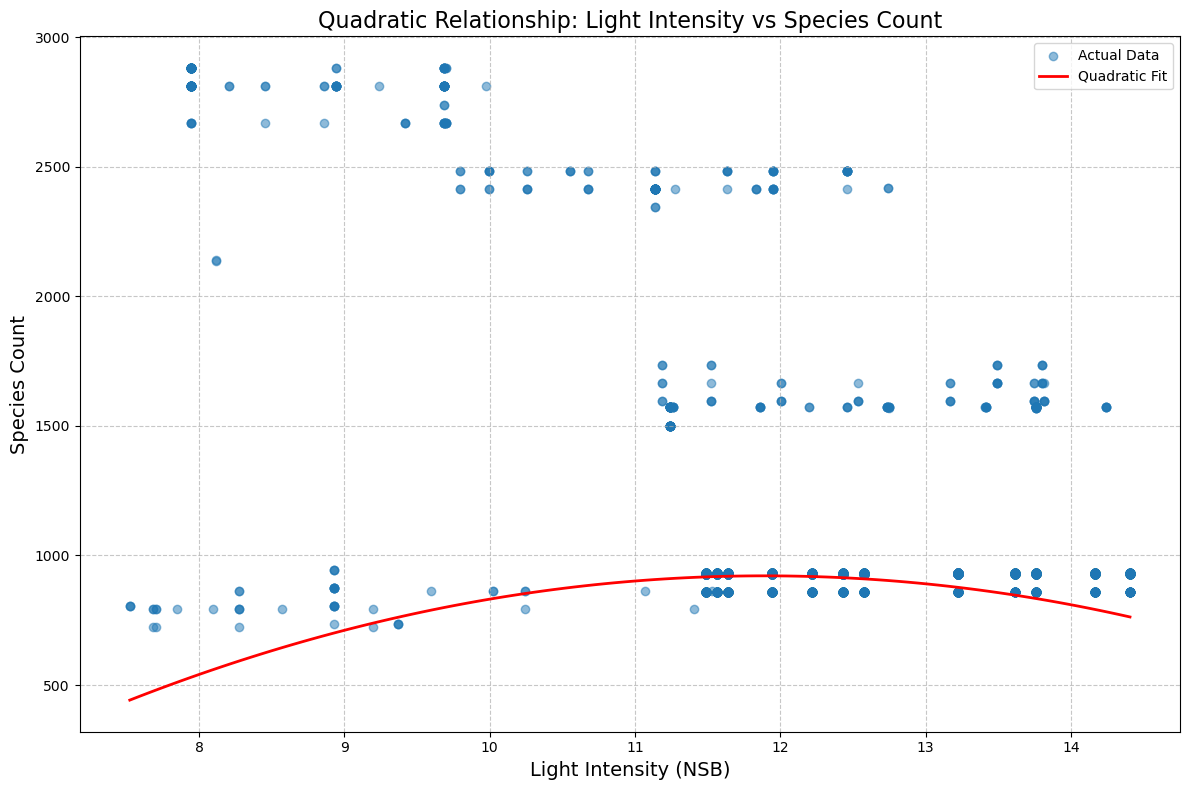

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# 创建一个新的数据框，用于多元回归分析
multi_reg_data = valid_data.copy()

# 提取唯一的观测点位置（使用经纬度组合）
location_pairs = multi_reg_data[['latitude_rounded', 'longitude_rounded']].drop_duplicates()
location_pairs = location_pairs.reset_index(drop=True)

# 只选择前9个最常见的观测点位置
top_locations = multi_reg_data.groupby(['latitude_rounded', 'longitude_rounded']).size().reset_index(name='count')
top_locations = top_locations.sort_values('count', ascending=False).head(9)
print(f"选择了{len(top_locations)}个最常见的观测点位置")

# 为每个观测点创建哑变量
for i, (_, row) in enumerate(top_locations.iterrows(), 1):
    lat, lon = row['latitude_rounded'], row['longitude_rounded']
    col_name = f'location_{i}'
    multi_reg_data[col_name] = ((multi_reg_data['latitude_rounded'] == lat) & 
                               (multi_reg_data['longitude_rounded'] == lon)).astype(int)

# 准备基础变量
X_columns = ['nsb'] + [f'location_{i}' for i in range(1, len(top_locations) + 1)]
X_base = multi_reg_data[X_columns]
y = multi_reg_data['gno']  # gno是物种数量

# 创建不同的模型并存储结果
models = []

# 模型1：基础多元回归模型（无交互项）
model1 = LinearRegression()
model1.fit(X_base, y)
y_pred1 = model1.predict(X_base)
r2_1 = r2_score(y, y_pred1)
rmse_1 = np.sqrt(mean_squared_error(y, y_pred1))
models.append({
    'name': 'Basic Multiple Regression',
    'model': model1,
    'features': X_columns,
    'R2': r2_1,
    'RMSE': rmse_1,
    'predictions': y_pred1
})

# 模型2：添加光照强度与位置的交互项
X_interact = X_base.copy()
for i in range(1, len(top_locations) + 1):
    col_name = f'nsb_x_loc{i}'
    X_interact[col_name] = X_base['nsb'] * X_base[f'location_{i}']

model2 = LinearRegression()
model2.fit(X_interact, y)
y_pred2 = model2.predict(X_interact)
r2_2 = r2_score(y, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y, y_pred2))
models.append({
    'name': 'Light × Location Interaction',
    'model': model2,
    'features': X_interact.columns.tolist(),
    'R2': r2_2,
    'RMSE': rmse_2,
    'predictions': y_pred2
})

# 模型3：添加光照强度的二次项
X_poly_nsb = X_base.copy()
X_poly_nsb['nsb_squared'] = X_base['nsb'] ** 2

model3 = LinearRegression()
model3.fit(X_poly_nsb, y)
y_pred3 = model3.predict(X_poly_nsb)
r2_3 = r2_score(y, y_pred3)
rmse_3 = np.sqrt(mean_squared_error(y, y_pred3))
models.append({
    'name': 'Quadratic Light Term',
    'model': model3,
    'features': X_poly_nsb.columns.tolist(),
    'R2': r2_3,
    'RMSE': rmse_3,
    'predictions': y_pred3
})

# 模型4：添加光照强度的二次项与位置的交互项
X_poly_interact = X_poly_nsb.copy()
for i in range(1, len(top_locations) + 1):
    col_name = f'nsb_squared_x_loc{i}'
    X_poly_interact[col_name] = X_poly_nsb['nsb_squared'] * X_base[f'location_{i}']

model4 = LinearRegression()
model4.fit(X_poly_interact, y)
y_pred4 = model4.predict(X_poly_interact)
r2_4 = r2_score(y, y_pred4)
rmse_4 = np.sqrt(mean_squared_error(y, y_pred4))
models.append({
    'name': 'Quadratic Light × Location',
    'model': model4,
    'features': X_poly_interact.columns.tolist(),
    'R2': r2_4,
    'RMSE': rmse_4,
    'predictions': y_pred4
})

# 模型5：使用PolynomialFeatures生成所有二次交互项
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_full = poly.fit_transform(X_base)
feature_names = poly.get_feature_names_out(X_base.columns)

model5 = LinearRegression()
model5.fit(X_poly_full, y)
y_pred5 = model5.predict(X_poly_full)
r2_5 = r2_score(y, y_pred5)
rmse_5 = np.sqrt(mean_squared_error(y, y_pred5))
models.append({
    'name': 'Full Polynomial Model',
    'model': model5,
    'features': feature_names.tolist(),
    'R2': r2_5,
    'RMSE': rmse_5,
    'predictions': y_pred5
})

# 打印所有模型的结果
print("\n模型比较:")
for model_info in models:
    print(f"\n{model_info['name']}:")
    print(f"R²: {model_info['R2']:.4f}")
    print(f"RMSE: {model_info['RMSE']:.4f}")
    
    # 打印前10个系数（如果特征太多）
    coefs = model_info['model'].coef_
    features = model_info['features']
    
    if len(features) > 10:
        print(f"前10个系数 (共{len(features)}个):")
        for i in range(10):
            print(f"  {features[i]}: {coefs[i]:.4f}")
    else:
        print("系数:")
        for i in range(len(features)):
            print(f"  {features[i]}: {coefs[i]:.4f}")
    
    print(f"截距: {model_info['model'].intercept_:.4f}")

# 可视化比较不同模型的R²和RMSE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R²比较
model_names = [model['name'] for model in models]
r2_values = [model['R2'] for model in models]

ax1.bar(model_names, r2_values, color='skyblue')
ax1.set_title('Models Comparison: R² Values', fontsize=16)
ax1.set_ylabel('R²', fontsize=14)
ax1.set_ylim([min(r2_values)*0.95, max(r2_values)*1.02])
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(r2_values):
    ax1.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

# RMSE比较
rmse_values = [model['RMSE'] for model in models]

ax2.bar(model_names, rmse_values, color='salmon')
ax2.set_title('Models Comparison: RMSE Values', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=14)
ax2.set_ylim([min(rmse_values)*0.95, max(rmse_values)*1.02])
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(rmse_values):
    ax2.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# 为每个模型创建实际值与预测值的对比图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, model_info in enumerate(models):
    if i < len(axes):
        ax = axes[i]
        y_pred = model_info['predictions']
        
        ax.scatter(y, y_pred, alpha=0.5)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        ax.set_title(f"{model_info['name']}\nR² = {model_info['R2']:.4f}, RMSE = {model_info['RMSE']:.4f}")
        ax.set_xlabel('Actual Species Count')
        ax.set_ylabel('Predicted Species Count')
        ax.grid(True, linestyle='--', alpha=0.7)

# 如果模型数量少于子图数量，隐藏多余的子图
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 残差分析：比较最佳模型与基础模型
best_model_idx = np.argmax([model['R2'] for model in models])
base_model_idx = 0  # 基础模型索引

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 基础模型残差
residuals_base = y - models[base_model_idx]['predictions']
axes[0].scatter(models[base_model_idx]['predictions'], residuals_base, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title(f'Residual Analysis: {models[base_model_idx]["name"]}')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, linestyle='--', alpha=0.7)

# 最佳模型残差
residuals_best = y - models[best_model_idx]['predictions']
axes[1].scatter(models[best_model_idx]['predictions'], residuals_best, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title(f'Residual Analysis: {models[best_model_idx]["name"]}')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 可视化最佳模型的特征重要性
best_model = models[best_model_idx]
features = best_model['features']
coefs = best_model['model'].coef_

# 如果特征太多，只显示绝对值最大的10个
if len(features) > 10:
    coef_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefs})
    coef_importance['Abs_Coefficient'] = coef_importance['Coefficient'].abs()
    coef_importance = coef_importance.sort_values('Abs_Coefficient', ascending=False).head(10)
    features = coef_importance['Feature'].tolist()
    coefs = coef_importance['Coefficient'].tolist()

plt.figure(figsize=(12, 8))
bars = plt.barh(features, coefs)

# 为正负系数设置不同颜色
for i, bar in enumerate(bars):
    if coefs[i] < 0:
        bar.set_color('salmon')
    else:
        bar.set_color('skyblue')

plt.title(f'Top Feature Coefficients: {best_model["name"]}', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 如果最佳模型包含光照强度的二次项，可视化其曲线拟合效果
if 'nsb_squared' in best_model['features']:
    plt.figure(figsize=(12, 8))
    
    # 绘制原始数据点
    plt.scatter(multi_reg_data['nsb'], y, alpha=0.5, label='Actual Data')
    
    # 创建光照强度的范围用于绘制曲线
    nsb_range = np.linspace(multi_reg_data['nsb'].min(), multi_reg_data['nsb'].max(), 100)
    
    # 预测值（假设其他变量为其平均值）
    X_pred = np.zeros((len(nsb_range), len(best_model['features'])))
    
    # 填充nsb和nsb_squared的值
    for i, feature in enumerate(best_model['features']):
        if feature == 'nsb':
            X_pred[:, i] = nsb_range
        elif feature == 'nsb_squared':
            X_pred[:, i] = nsb_range ** 2
        else:
            # 对于位置变量，使用其平均值
            X_pred[:, i] = X_base[feature].mean() if feature in X_base.columns else 0
    
    # 预测
    y_curve = best_model['model'].predict(X_pred)
    
    # 绘制曲线
    plt.plot(nsb_range, y_curve, 'r-', linewidth=2, label='Quadratic Fit')
    
    plt.title('Quadratic Relationship: Light Intensity vs Species Count', fontsize=16)
    plt.xlabel('Light Intensity (NSB)', fontsize=14)
    plt.ylabel('Species Count', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()



正在训练分段回归模型...
分段回归的分割点: 1806.32
低值段数据点: 2737, 高值段数据点: 237

正在训练随机森林回归模型...

正在训练混合回归模型...

正在训练神经网络回归模型...

创建集成模型...
选择的最佳模型: 随机森林回归, 分段回归模型, 混合回归模型

模型性能比较:
       模型        R²        RMSE        MAE      相关系数   p值     训练集R²     测试集R²    交叉验证R²
1  随机森林回归  0.986377   57.495137   6.504108  0.993167  0.0  0.994011  0.960196  0.953658
5  加权平均集成  0.984987   60.357856  28.021748  0.992489  0.0  0.986705  0.979059       NaN
4  简单平均集成  0.984926   60.480047  28.124996  0.992458  0.0  0.986625  0.979064       NaN
0  分段回归模型  0.974231   79.077637  40.764963  0.987032  0.0  0.973921  0.975212  0.973812
2  混合回归模型  0.974221   79.092686  40.660339  0.987026  0.0  0.973905  0.975224       NaN
3  神经网络回归  0.887366  165.324138  77.949771  0.942118  0.0  0.897075  0.853779  0.891068


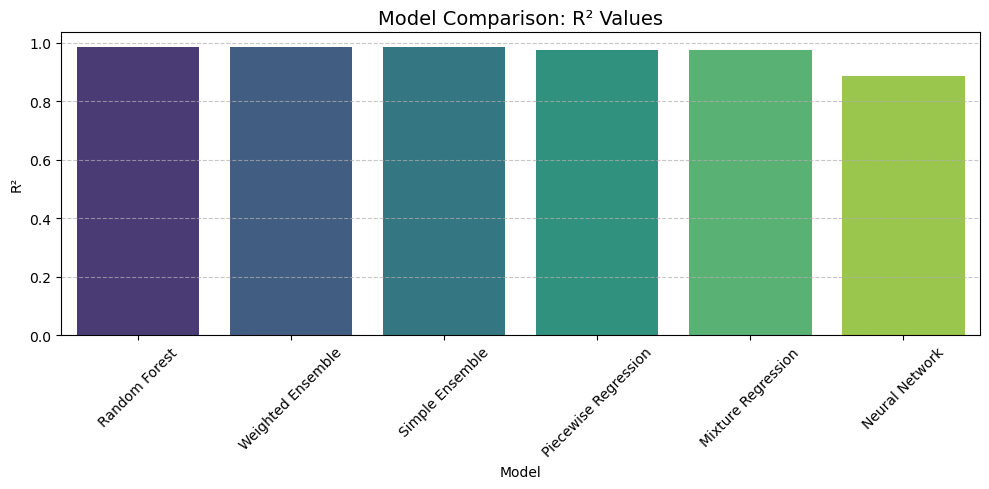

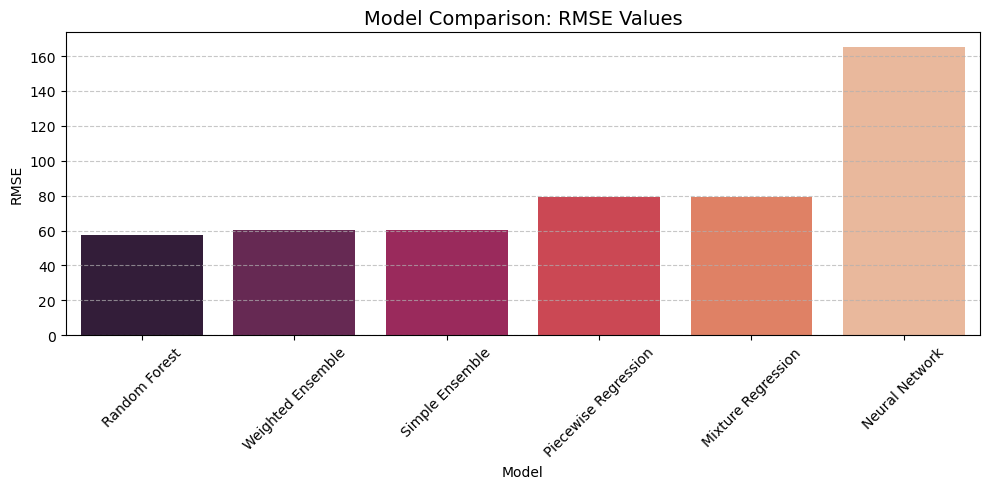

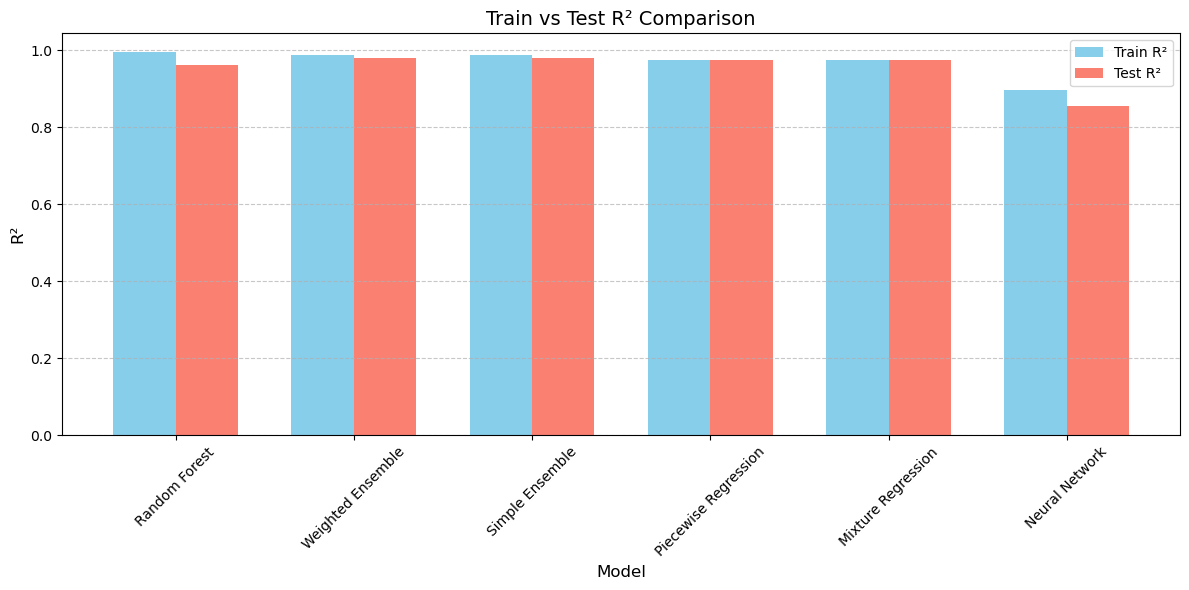


最佳模型: 随机森林回归 (R² = 0.9864)


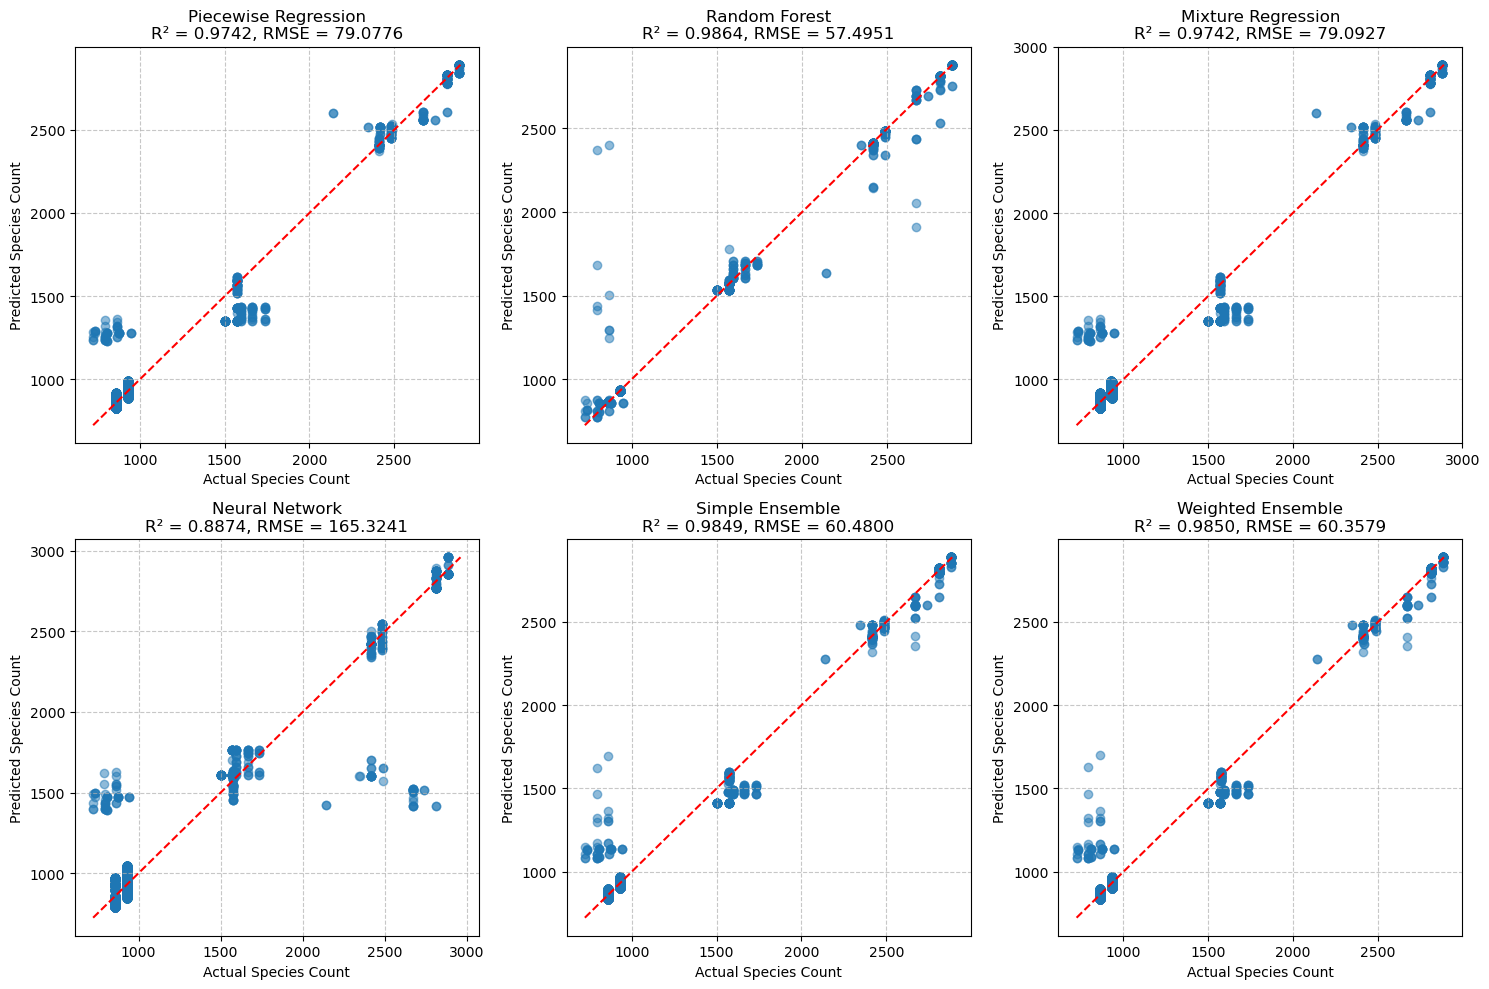

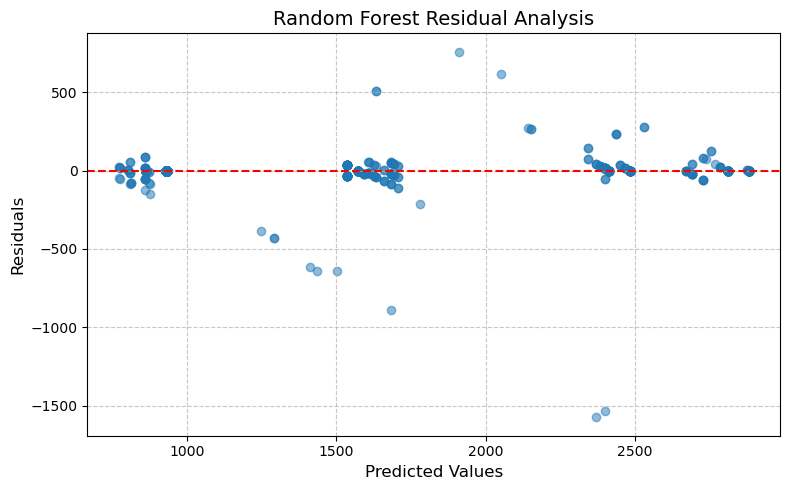

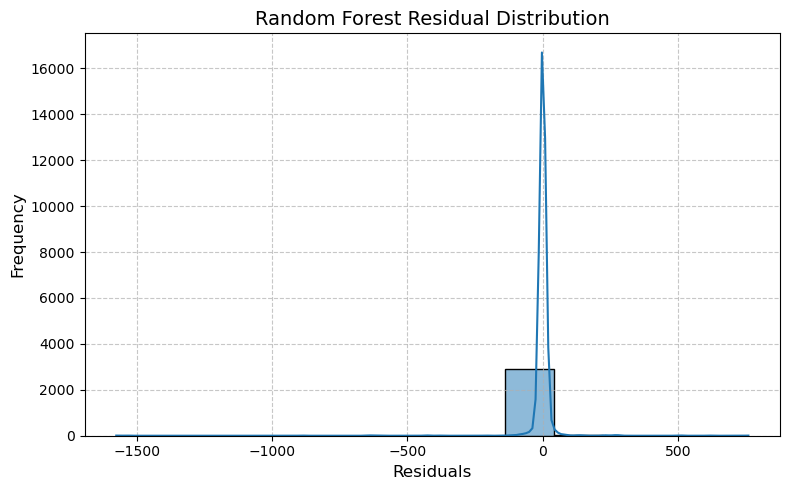

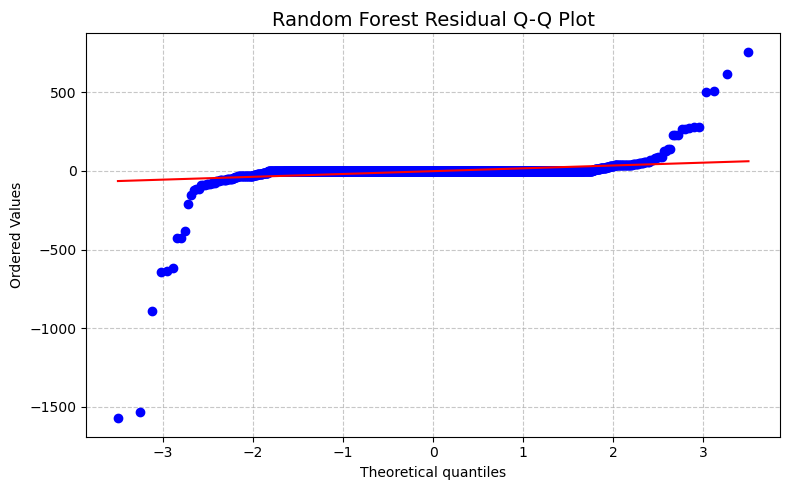

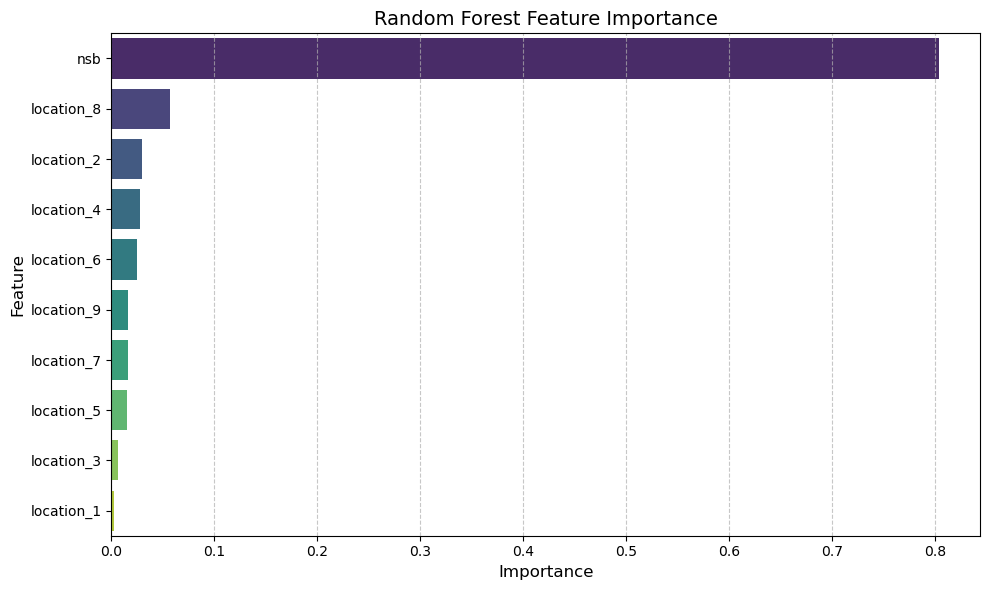


分析光照强度(NSB)与物种数量的关系...


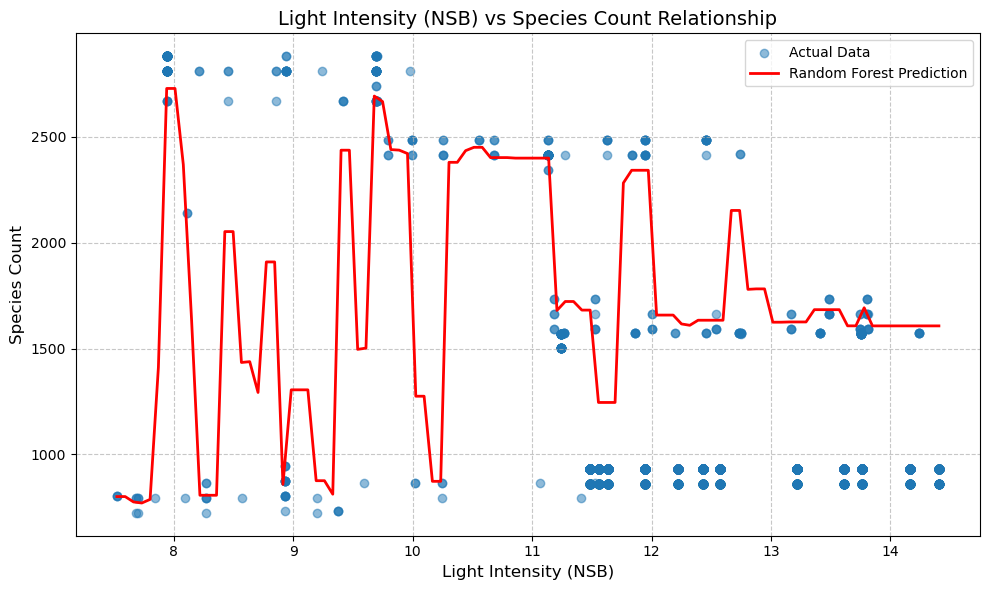


===== 最终结论 =====
最佳模型: 随机森林回归
R²: 0.9864
RMSE: 57.4951
MAE: 6.5041
相关系数: 0.9932
p值: 0.00000000
训练集R²: 0.9940
测试集R²: 0.9602

特征重要性排名:
1. nsb: 0.8032
2. location_8: 0.0572
3. location_2: 0.0295
4. location_4: 0.0277
5. location_6: 0.0251
6. location_9: 0.0166
7. location_7: 0.0165
8. location_5: 0.0155
9. location_3: 0.0064
10. location_1: 0.0023

相比于基础模型，最佳模型提高了 1.25% 的R²

模型应用建议:
- 模型拟合度非常好，可以用于预测和决策支持

影响物种数量的主要因素:
- 根据模型分析，最重要的三个因素是: nsb, location_8, location_2


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from sklearn.cluster import KMeans
import warnings
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8, 5]

warnings.filterwarnings('ignore')

# 假设数据已经准备好，包含特征和目标变量
# 如果需要修改特征列名，请在此处更改
X_columns = ['nsb'] + [f'location_{i}' for i in range(1, len(top_locations) + 1)]
X = multi_reg_data[X_columns]
y = multi_reg_data['gno']  # 物种数量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 存储所有模型结果
all_models = []

# 1. 分段回归模型
def fit_piecewise_regression():
    print("\n正在训练分段回归模型...")
    
    # 使用KMeans确定分割点
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(np.array(y).reshape(-1, 1))
    
    # 根据聚类结果分割数据
    df_with_clusters = X.copy()
    df_with_clusters['target'] = y
    df_with_clusters['cluster'] = clusters
    
    # 获取两个簇的中心点
    centers = kmeans.cluster_centers_.flatten()
    split_point = (centers[0] + centers[1]) / 2
    print(f"分段回归的分割点: {split_point:.2f}")
    
    # 分割数据
    low_mask = y <= split_point
    high_mask = y > split_point
    
    X_low, y_low = X[low_mask], y[low_mask]
    X_high, y_high = X[high_mask], y[high_mask]
    
    print(f"低值段数据点: {len(X_low)}, 高值段数据点: {len(X_high)}")
    
    # 训练两个线性回归模型
    model_low = LinearRegression().fit(X_low, y_low)
    model_high = LinearRegression().fit(X_high, y_high)
    
    # 预测
    y_pred = np.zeros_like(y)
    y_pred[low_mask] = model_low.predict(X_low)
    y_pred[high_mask] = model_high.predict(X_high)
    
    # 计算统计指标
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # 计算相关系数和p值
    correlation, p_value = stats.pearsonr(y, y_pred)
    
    # 对训练集和测试集分别评估
    y_train_pred = np.zeros_like(y_train)
    train_low_mask = y_train <= split_point
    train_high_mask = y_train > split_point
    y_train_pred[train_low_mask] = model_low.predict(X_train[train_low_mask])
    y_train_pred[train_high_mask] = model_high.predict(X_train[train_high_mask])
    
    y_test_pred = np.zeros_like(y_test)
    test_low_mask = y_test <= split_point
    test_high_mask = y_test > split_point
    y_test_pred[test_low_mask] = model_low.predict(X_test[test_low_mask])
    y_test_pred[test_high_mask] = model_high.predict(X_test[test_high_mask])
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 交叉验证
    cv_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
        y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 确定每个折叠的分割点
        cv_low_mask = y_cv_train <= split_point
        cv_high_mask = y_cv_train > split_point
        
        cv_model_low = LinearRegression().fit(X_cv_train[cv_low_mask], y_cv_train[cv_low_mask])
        cv_model_high = LinearRegression().fit(X_cv_train[cv_high_mask], y_cv_train[cv_high_mask])
        
        y_cv_pred = np.zeros_like(y_cv_val)
        cv_val_low_mask = y_cv_val <= split_point
        cv_val_high_mask = y_cv_val > split_point
        
        if sum(cv_val_low_mask) > 0:
            y_cv_pred[cv_val_low_mask] = cv_model_low.predict(X_cv_val[cv_val_low_mask])
        if sum(cv_val_high_mask) > 0:
            y_cv_pred[cv_val_high_mask] = cv_model_high.predict(X_cv_val[cv_val_high_mask])
        
        cv_scores.append(r2_score(y_cv_val, y_cv_pred))
    
    cv_r2 = np.mean(cv_scores)
    
    # 保存模型结果
    model_info = {
        'name': '分段回归模型',
        'name_en': 'Piecewise Regression',
        'model': (model_low, model_high, split_point),
        'predictions': y_pred,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation,
        'p_value': p_value,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2': cv_r2
    }
    
    all_models.append(model_info)
    return model_info

# 2. 随机森林回归
def fit_random_forest():
    print("\n正在训练随机森林回归模型...")
    
    # 训练模型
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # 预测
    y_pred = rf.predict(X)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # 计算统计指标
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # 计算相关系数和p值
    correlation, p_value = stats.pearsonr(y, y_pred)
    
    # 训练集和测试集评估
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
    cv_r2 = np.mean(cv_scores)
    
    # 特征重要性
    feature_importance = pd.DataFrame({
        'feature': X_columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 保存模型结果
    model_info = {
        'name': '随机森林回归',
        'name_en': 'Random Forest',
        'model': rf,
        'predictions': y_pred,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation,
        'p_value': p_value,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2': cv_r2,
        'feature_importance': feature_importance
    }
    
    all_models.append(model_info)
    return model_info

# 3. 混合回归模型
def fit_mixture_regression():
    print("\n正在训练混合回归模型...")
    
    # 使用高斯混合模型对数据进行聚类
    gmm = GaussianMixture(n_components=2, random_state=42)
    # 将y添加到特征中进行聚类，以便更好地捕捉双峰分布
    clusters = gmm.fit_predict(np.column_stack((X, y)))
    
    # 为每个聚类创建单独的模型
    models = []
    y_pred = np.zeros_like(y, dtype=float)
    y_train_pred = np.zeros_like(y_train, dtype=float)
    y_test_pred = np.zeros_like(y_test, dtype=float)
    
    for cluster in np.unique(clusters):
        mask = (clusters == cluster)
        X_cluster = X[mask]
        y_cluster = y[mask]
        
        # 训练线性回归模型
        model = LinearRegression()
        model.fit(X_cluster, y_cluster)
        models.append(model)
        
        # 为整个数据集预测
        # 注意：这里我们需要计算每个点属于这个簇的概率
        probs = gmm.predict_proba(np.column_stack((X, y)))[:, cluster]
        y_pred += probs * model.predict(X)
        
        # 为训练集和测试集预测
        train_probs = gmm.predict_proba(np.column_stack((X_train, y_train)))[:, cluster]
        test_probs = gmm.predict_proba(np.column_stack((X_test, y_test)))[:, cluster]
        
        y_train_pred += train_probs * model.predict(X_train)
        y_test_pred += test_probs * model.predict(X_test)
    
    # 计算统计指标
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # 计算相关系数和p值
    correlation, p_value = stats.pearsonr(y, y_pred)
    
    # 训练集和测试集评估
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 交叉验证（简化版本，不进行完整的GMM+回归交叉验证）
    cv_r2 = np.nan  # 混合模型的交叉验证比较复杂
    
    # 保存模型结果
    model_info = {
        'name': '混合回归模型',
        'name_en': 'Mixture Regression',
        'model': (models, gmm),
        'predictions': y_pred,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation,
        'p_value': p_value,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2': cv_r2,
        'clusters': clusters
    }
    
    all_models.append(model_info)
    return model_info

# 4. 神经网络回归
def fit_neural_network():
    print("\n正在训练神经网络回归模型...")
    
    # 训练模型
    nn = MLPRegressor(
        hidden_layer_sizes=(64, 32, 16),
        activation='relu',
        solver='adam',
        alpha=0.001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    )
    nn.fit(X_train, y_train)
    
    # 预测
    y_pred = nn.predict(X)
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    
    # 计算统计指标
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # 计算相关系数和p值
    correlation, p_value = stats.pearsonr(y, y_pred)
    
    # 训练集和测试集评估
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(nn, X, y, cv=5, scoring='r2')
    cv_r2 = np.mean(cv_scores)
    
    # 特征重要性（使用排列重要性）
    perm_importance = permutation_importance(nn, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = pd.DataFrame({
        'feature': X_columns,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    # 保存模型结果
    model_info = {
        'name': '神经网络回归',
        'name_en': 'Neural Network',
        'model': nn,
        'predictions': y_pred,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'correlation': correlation,
        'p_value': p_value,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2': cv_r2,
        'feature_importance': feature_importance
    }
    
    all_models.append(model_info)
    return model_info

# 运行所有模型
piecewise_model = fit_piecewise_regression()
rf_model = fit_random_forest()
mixture_model = fit_mixture_regression()
nn_model = fit_neural_network()

# 创建集成模型
def create_ensemble_model():
    print("\n创建集成模型...")
    
    # 选择表现最好的三个模型
    models_to_ensemble = sorted(all_models, key=lambda x: x['r2'], reverse=True)[:3]
    model_names = [model['name'] for model in models_to_ensemble]
    model_names_en = [model['name_en'] for model in models_to_ensemble]
    print(f"选择的最佳模型: {', '.join(model_names)}")
    
    # 简单平均集成
    y_pred_avg = np.mean([model['predictions'] for model in models_to_ensemble], axis=0)
    y_train_pred_avg = np.mean([model['train_predictions'] for model in models_to_ensemble], axis=0)
    y_test_pred_avg = np.mean([model['test_predictions'] for model in models_to_ensemble], axis=0)
    
    # 加权平均集成（根据R²值计算权重）
    weights = [model['r2'] for model in models_to_ensemble]
    sum_weights = sum(weights)
    weights = [w/sum_weights for w in weights]
    
    y_pred_weighted = np.zeros_like(y, dtype=float)
    y_train_pred_weighted = np.zeros_like(y_train, dtype=float)
    y_test_pred_weighted = np.zeros_like(y_test, dtype=float)
    
    for i, model in enumerate(models_to_ensemble):
        y_pred_weighted += weights[i] * model['predictions']
        y_train_pred_weighted += weights[i] * model['train_predictions']
        y_test_pred_weighted += weights[i] * model['test_predictions']
    
    # 计算简单平均集成的统计指标
    r2_avg = r2_score(y, y_pred_avg)
    rmse_avg = np.sqrt(mean_squared_error(y, y_pred_avg))
    mae_avg = mean_absolute_error(y, y_pred_avg)
    correlation_avg, p_value_avg = stats.pearsonr(y, y_pred_avg)
    train_r2_avg = r2_score(y_train, y_train_pred_avg)
    test_r2_avg = r2_score(y_test, y_test_pred_avg)
    
    # 计算加权平均集成的统计指标
    r2_weighted = r2_score(y, y_pred_weighted)
    rmse_weighted = np.sqrt(mean_squared_error(y, y_pred_weighted))
    mae_weighted = mean_absolute_error(y, y_pred_weighted)
    correlation_weighted, p_value_weighted = stats.pearsonr(y, y_pred_weighted)
    train_r2_weighted = r2_score(y_train, y_train_pred_weighted)
    test_r2_weighted = r2_score(y_test, y_test_pred_weighted)
    
    # 保存简单平均集成模型结果
    ensemble_avg_info = {
        'name': '简单平均集成',
        'name_en': 'Simple Ensemble',
        'model': 'ensemble_avg',
        'predictions': y_pred_avg,
        'train_predictions': y_train_pred_avg,
        'test_predictions': y_test_pred_avg,
        'r2': r2_avg,
        'rmse': rmse_avg,
        'mae': mae_avg,
        'correlation': correlation_avg,
        'p_value': p_value_avg,
        'train_r2': train_r2_avg,
        'test_r2': test_r2_avg,
        'cv_r2': np.nan  # 集成模型没有直接的交叉验证
    }
    
    # 保存加权平均集成模型结果
    ensemble_weighted_info = {
        'name': '加权平均集成',
        'name_en': 'Weighted Ensemble',
        'model': ('ensemble_weighted', weights, model_names_en),
        'predictions': y_pred_weighted,
        'train_predictions': y_train_pred_weighted,
        'test_predictions': y_test_pred_weighted,
        'r2': r2_weighted,
        'rmse': rmse_weighted,
        'mae': mae_weighted,
        'correlation': correlation_weighted,
        'p_value': p_value_weighted,
        'train_r2': train_r2_weighted,
        'test_r2': test_r2_weighted,
        'cv_r2': np.nan  # 集成模型没有直接的交叉验证
    }
    
    all_models.append(ensemble_avg_info)
    all_models.append(ensemble_weighted_info)
    
    return ensemble_avg_info, ensemble_weighted_info

# 创建集成模型
ensemble_avg_model, ensemble_weighted_model = create_ensemble_model()

# 显示所有模型的性能比较
def display_model_comparison():
    # 创建性能比较表格
    performance_df = pd.DataFrame({
        '模型': [model['name'] for model in all_models],
        'Model': [model['name_en'] for model in all_models],
        'R²': [model['r2'] for model in all_models],
        'RMSE': [model['rmse'] for model in all_models],
        'MAE': [model['mae'] for model in all_models],
        '相关系数': [model['correlation'] for model in all_models],
        'p值': [model['p_value'] for model in all_models],
        '训练集R²': [model['train_r2'] for model in all_models],
        '测试集R²': [model['test_r2'] for model in all_models],
        '交叉验证R²': [model['cv_r2'] for model in all_models]
    })
    
    # 按R²降序排序
    performance_df = performance_df.sort_values('R²', ascending=False)
    
    # 显示性能比较表格
    print("\n模型性能比较:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(performance_df[['模型', 'R²', 'RMSE', 'MAE', '相关系数', 'p值', '训练集R²', '测试集R²', '交叉验证R²']])
    
    # 可视化R²比较
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='R²', data=performance_df, palette='viridis')
    plt.title('Model Comparison: R² Values', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 可视化RMSE比较
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='RMSE', data=performance_df, palette='rocket')
    plt.title('Model Comparison: RMSE Values', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 可视化训练集vs测试集R²
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(performance_df))
    width = 0.35
    
    plt.bar(x - width/2, performance_df['训练集R²'], width, label='Train R²', color='skyblue')
    plt.bar(x + width/2, performance_df['测试集R²'], width, label='Test R²', color='salmon')
    
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('R²', fontsize=12)
    plt.title('Train vs Test R² Comparison', fontsize=14)
    plt.xticks(x, performance_df['Model'], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return performance_df

# 可视化预测结果
def visualize_predictions():
    # 选择表现最好的模型
    best_model = max(all_models, key=lambda x: x['r2'])
    print(f"\n最佳模型: {best_model['name']} (R² = {best_model['r2']:.4f})")
    
    # 创建实际值vs预测值的对比图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, model in enumerate(all_models[:6]):  # 最多显示6个模型
        if i < len(axes):
            ax = axes[i]
            
            # 绘制散点图
            ax.scatter(y, model['predictions'], alpha=0.5)
            
            # 添加对角线
            min_val = min(min(y), min(model['predictions']))
            max_val = max(max(y), max(model['predictions']))
            ax.plot([min_val, max_val], [min_val, max_val], 'r--')
            
            # 添加标题和标签
            ax.set_title(f"{model['name_en']}\nR² = {model['r2']:.4f}, RMSE = {model['rmse']:.4f}")
            ax.set_xlabel('Actual Species Count')
            ax.set_ylabel('Predicted Species Count')
            ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # 绘制最佳模型的残差图
    plt.figure(figsize=(8, 5))
    residuals = y - best_model['predictions']
    plt.scatter(best_model['predictions'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{best_model["name_en"]} Residual Analysis', fontsize=14)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 绘制残差直方图
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True)
    plt.title(f'{best_model["name_en"]} Residual Distribution', fontsize=14)
    plt.xlabel('Residuals', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 绘制Q-Q图检验残差的正态性
    plt.figure(figsize=(8, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'{best_model["name_en"]} Residual Q-Q Plot', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 如果是随机森林或神经网络模型，显示特征重要性
    if 'feature_importance' in best_model:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x='importance', 
            y='feature', 
            data=best_model['feature_importance'].head(10),
            palette='viridis'
        )
        plt.title(f'{best_model["name_en"]} Feature Importance', fontsize=14)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # 如果是分段回归模型，显示分段效果
    if best_model['name'] == '分段回归模型':
        plt.figure(figsize=(8, 5))
        
        # 获取分割点
        split_point = best_model['model'][2]
        
        # 绘制散点图，按分段着色
        low_mask = y <= split_point
        high_mask = y > split_point
        
        plt.scatter(y[low_mask], best_model['predictions'][low_mask], 
                   alpha=0.5, label=f'Low Segment (≤{split_point:.2f})', color='blue')
        plt.scatter(y[high_mask], best_model['predictions'][high_mask], 
                   alpha=0.5, label=f'High Segment (>{split_point:.2f})', color='red')
        
        # 添加对角线
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
        
        plt.title(f'Piecewise Regression: R² = {best_model["r2"]:.4f}', fontsize=14)
        plt.xlabel('Actual Species Count', fontsize=12)
        plt.ylabel('Predicted Species Count', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # 如果是混合回归模型，显示聚类效果
    if best_model['name'] == '混合回归模型':
        plt.figure(figsize=(8, 5))
        
        # 绘制散点图，按聚类着色
        clusters = best_model['clusters']
        
        for cluster in np.unique(clusters):
            mask = clusters == cluster
            plt.scatter(y[mask], best_model['predictions'][mask], 
                       alpha=0.5, label=f'Cluster {cluster}')
        
        # 添加对角线
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
        
        plt.title(f'Mixture Regression: R² = {best_model["r2"]:.4f}', fontsize=14)
        plt.xlabel('Actual Species Count', fontsize=12)
        plt.ylabel('Predicted Species Count', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# 执行模型比较和可视化
performance_df = display_model_comparison()
visualize_predictions()

# 额外的分析：光照强度(nsb)与物种数量的关系
def analyze_nsb_relationship():
    print("\n分析光照强度(NSB)与物种数量的关系...")
    
    # 获取最佳模型
    best_model = max(all_models, key=lambda x: x['r2'])
    
    plt.figure(figsize=(10, 6))
    
    # 绘制原始数据点
    plt.scatter(multi_reg_data['nsb'], y, alpha=0.5, label='Actual Data')
    
    # 如果是随机森林或神经网络模型，绘制部分依赖图
    if best_model['name'] in ['随机森林回归', '神经网络回归']:
        # 创建NSB范围
        nsb_range = np.linspace(multi_reg_data['nsb'].min(), multi_reg_data['nsb'].max(), 100)
        
        # 创建预测数据框架，其他特征设为平均值
        X_pred = np.tile(X.mean(axis=0), (len(nsb_range), 1))
        X_pred[:, 0] = nsb_range  # 假设nsb是第一个特征
        
        # 预测
        y_pred = best_model['model'].predict(X_pred)
        
        # 绘制预测曲线
        plt.plot(nsb_range, y_pred, 'r-', linewidth=2, 
                label=f'{best_model["name_en"]} Prediction')
    
    # 如果是分段回归模型，绘制分段预测曲线
    elif best_model['name'] == '分段回归模型':
        model_low, model_high, split_point = best_model['model']
        
        # 创建NSB范围
        nsb_low = np.linspace(multi_reg_data['nsb'].min(), multi_reg_data['nsb'].max(), 50)
        nsb_high = np.linspace(multi_reg_data['nsb'].min(), multi_reg_data['nsb'].max(), 50)
        
        # 创建预测数据框架，其他特征设为平均值
        X_pred_low = np.tile(X.mean(axis=0), (len(nsb_low), 1))
        X_pred_low[:, 0] = nsb_low  # 假设nsb是第一个特征
        
        X_pred_high = np.tile(X.mean(axis=0), (len(nsb_high), 1))
        X_pred_high[:, 0] = nsb_high  # 假设nsb是第一个特征
        
        # 预测
        y_pred_low = model_low.predict(X_pred_low)
        y_pred_high = model_high.predict(X_pred_high)
        
        # 绘制预测曲线
        plt.plot(nsb_low, y_pred_low, 'b-', linewidth=2, 
                label=f'Low Segment Prediction (≤{split_point:.2f})')
        plt.plot(nsb_high, y_pred_high, 'r-', linewidth=2, 
                label=f'High Segment Prediction (>{split_point:.2f})')
    
    # 如果是混合回归模型，绘制混合预测曲线
    elif best_model['name'] == '混合回归模型':
        models, gmm = best_model['model']
        
        # 创建NSB范围
        nsb_range = np.linspace(multi_reg_data['nsb'].min(), multi_reg_data['nsb'].max(), 100)
        
        # 创建预测数据框架，其他特征设为平均值
        X_pred = np.tile(X.mean(axis=0), (len(nsb_range), 1))
        X_pred[:, 0] = nsb_range  # 假设nsb是第一个特征
        
        # 预测每个簇的结果
        y_preds = []
        for i, model in enumerate(models):
            y_pred_cluster = model.predict(X_pred)
            y_preds.append(y_pred_cluster)
            plt.plot(nsb_range, y_pred_cluster, '--', linewidth=1, 
                    label=f'Cluster {i} Prediction', alpha=0.5)
        
        # 计算加权平均预测
        y_pred_weighted = np.zeros((len(nsb_range),))
        for i, y_pred_cluster in enumerate(y_preds):
            # 简化：使用固定权重
            y_pred_weighted += y_pred_cluster / len(models)
        
        # 绘制加权平均预测曲线
        plt.plot(nsb_range, y_pred_weighted, 'r-', linewidth=2, 
                label='Mixture Model Prediction')
    
    plt.title('Light Intensity (NSB) vs Species Count Relationship', fontsize=14)
    plt.xlabel('Light Intensity (NSB)', fontsize=12)
    plt.ylabel('Species Count', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 执行光照强度关系分析
analyze_nsb_relationship()

# 打印最终结论
def print_conclusion():
    # 获取最佳模型
    best_model = max(all_models, key=lambda x: x['r2'])
    
    print("\n===== 最终结论 =====")
    print(f"最佳模型: {best_model['name']}")
    print(f"R²: {best_model['r2']:.4f}")
    print(f"RMSE: {best_model['rmse']:.4f}")
    print(f"MAE: {best_model['mae']:.4f}")
    print(f"相关系数: {best_model['correlation']:.4f}")
    print(f"p值: {best_model['p_value']:.8f}")
    print(f"训练集R²: {best_model['train_r2']:.4f}")
    print(f"测试集R²: {best_model['test_r2']:.4f}")
    
    if best_model['name'] == '随机森林回归':
        print("\n特征重要性排名:")
        for i, (feature, importance) in enumerate(zip(best_model['feature_importance']['feature'], 
                                                    best_model['feature_importance']['importance'])):
            print(f"{i+1}. {feature}: {importance:.4f}")
    
    # 计算模型改进百分比
    base_r2 = all_models[0]['r2']  # 假设第一个模型是基准模型
    improvement = (best_model['r2'] - base_r2) / base_r2 * 100
    
    print(f"\n相比于基础模型，最佳模型提高了 {improvement:.2f}% 的R²")
    
    # 输出模型建议
    print("\n模型应用建议:")
    if best_model['r2'] > 0.8:
        print("- 模型拟合度非常好，可以用于预测和决策支持")
    elif best_model['r2'] > 0.6:
        print("- 模型拟合度良好，可以用于一般预测和趋势分析")
    else:
        print("- 模型拟合度一般，建议仅用于粗略估计和趋势分析")
    
    if best_model['train_r2'] - best_model['test_r2'] > 0.1:
        print("- 存在一定过拟合风险，建议在应用时增加正则化或减少模型复杂度")
    
    print("\n影响物种数量的主要因素:")
    if 'feature_importance' in best_model:
        top_features = best_model['feature_importance'].head(3)['feature'].tolist()
        print(f"- 根据模型分析，最重要的三个因素是: {', '.join(top_features)}")
    else:
        print("- 需要进一步分析模型系数来确定主要影响因素")

# 打印结论
print_conclusion()

